# Dataset Construction

This notebook constructs the datasets used in the analyses. To see the actual statistical analyses, see the R scripts.

First load the PWC provided data. "evaluation-tables.json" and "papers-with-abstracts.json" were downloaded from [PWC's Github](https://github.com/paperswithcode/paperswithcode-data) on 06/16/2021.

In [1]:
DATASET_PATH="/mnt/c/Users/berna/Documents/GitHub/Life_of_a_Benchmark/Dataset_Curation"
import pandas as pd
import json
with open('./PWC_Data/papers-with-abstracts.json') as f:
    pwc=json.load(f)
with open('./PWC_Data/evaluation-tables.json') as f:
    benchmark_tables=json.load(f)

[Errno 2] No such file or directory: 'DATASET_PATH'
/mnt/c/Users/berna/Documents/GitHub/Life_of_a_Benchmark/Dataset_Curation


### Construct Task Ontology

This block parses "evaluation-tables.json" to create a task ontology. Benchmarks in this file are organized by task and subtask.

In [255]:
all_rows=[] #used to construct benchmark_papers df
parent_child_dict={} #dictionary capturing parent-child task relations used to create task_relations df
child_parent_dict={} #inverse of above
task_category_dict={} #captures task category relations: categories in PWC are larger domains like "NLP","CV","Methodology
paper_titles_tasks={} #paper titles to tasks
paper_titles_parent_tasks={} #paper totiles to parent tasks
dataset_associated_tasks={} # tasks associated with the dataset

for i, task in enumerate(benchmark_tables):
    task_dict={} # A dictionary for each task that will ultimately be a row in the benchmark_papers dataframe
    task_dict['task']=task['task']
    task_dict['task_categories']=task['categories']
    task_dict['task_description']=task['description']
    task_dict['parent_task']=task['task']
    if task['task'] not in parent_child_dict: parent_child_dict[task['task']]=[]
    if task['task'] not in child_parent_dict: child_parent_dict[task['task']]=[]
    task_category_dict[task['task']]=task['categories']
    if len(task['datasets'])!=0: #if there are datasets associated with task
        for j,d in enumerate(task['datasets']):
            if d['dataset'] not in dataset_associated_tasks:dataset_associated_tasks[d['dataset']]=[]
            parent_dataset=d['dataset'] # variations of datasets can be listed as "children"
            dataset_associated_tasks[d['dataset']].append(task['task'])
            dataset_dict={}
            dataset_dict.update(task_dict)
            dataset_dict['dataset']=d['dataset']
            dataset_dict['dataset_citations']=d['dataset_citations']
            dataset_dict['dataset_links']=d['dataset_links']
            dataset_dict['dataset_subdatasets']=d['subdatasets']
            dataset_dict['task']=task['task']
            for row in d['sota']['rows']:
                for m in row['metrics']:
                    row_dict=dict(row)
                    row_dict['metrics']=m
                    row_dict['score']=row['metrics'][m]
                    row_dict.update(dataset_dict)
                    all_rows.append(row_dict)
                if row['paper_title'] not in paper_titles_tasks:paper_titles_tasks[row['paper_title']]=[]
                if row['paper_title'] not in paper_titles_parent_tasks:paper_titles_parent_tasks[row['paper_title']]=[]
                paper_titles_tasks[row['paper_title']]+=[task['task']]
                paper_titles_parent_tasks[row['paper_title']]+=[task['task']]
    if len(task['subtasks'])!=0: #tasks can have subtasks. This is not tree. A subtask could have multiple parents or be a parent itself.
        for t in task['subtasks']:
            task_dict={} #Each subtask is it's own row also
            if t['task'] not in child_parent_dict: child_parent_dict[t['task']]=[]
            if t['task'] not in parent_child_dict: parent_child_dict[t['task']]=[]
            task_category_dict[t['task']]=t['categories']
            parent_child_dict[task['task']].append(t['task'])
            child_parent_dict[t['task']].append(task['task'])
            
            task_dict['parent_task']=task['task']
            task_dict['task']=t['task']
            task_dict['task_categories']=','.join(t['categories'])
            task_dict['task_description']=t['description']
            
            if len(t['datasets'])!=0:
                for d in t['datasets']:
                    if d['dataset'] not in dataset_associated_tasks:dataset_associated_tasks[d['dataset']]=[]
                    dataset_associated_tasks[d['dataset']].append(t['task'])
                    dataset_associated_tasks[parent_dataset].append(t['task'])
                    dataset_dict={}
                    dataset_dict.update(task_dict)
                    dataset_dict['dataset']=d['dataset']
                    dataset_dict['dataset_citations']=d['dataset_citations']
                    dataset_dict['dataset_links']=d['dataset_links']
                    dataset_dict['dataset_subdatasets']=d['subdatasets']
                    dataset_dict['task']=t['task']
                    for row in d['sota']['rows']:
                        for m in row['metrics']:
                            row_dict=dict(row)
                            row_dict['metrics']=m
                            row_dict['score']=row['metrics'][m]
                            row_dict.update(dataset_dict)
                            all_rows.append(row_dict)
                        if row['paper_title'] not in paper_titles_tasks:paper_titles_tasks[row['paper_title']]=[]
                        paper_titles_tasks[row['paper_title']]+=[t['task']] 
                        if row['paper_title'] not in paper_titles_parent_tasks:paper_titles_parent_tasks[row['paper_title']]=[]
                        paper_titles_parent_tasks[row['paper_title']]+=[task['task']] 

#contains all relevant info at papers used in benchmarks
benchmark_papers=pd.DataFrame(all_rows)
benchmark_papers=benchmark_papers.drop_duplicates(['model_name','dataset','task','metrics','score'])
benchmark_papers['benchmark_id']=benchmark_papers.groupby(['task','dataset','metrics']).ngroup()
benchmark_papers=benchmark_papers[['paper_title','paper_date','task','parent_task','dataset','score','benchmark_id','metrics','task_categories']]
benchmark_papers=benchmark_papers.drop_duplicates(['paper_title','paper_date','task','parent_task','dataset','score','benchmark_id','metrics'])
benchmark_papers['CV']=benchmark_papers.apply(lambda row: 'Computer Vision' in row['task_categories'] and len(row['task_categories'])==1,axis=1 )
benchmark_papers['NLP']=benchmark_papers.apply(lambda row: 'Natural Language Processing' in row['task_categories'] and len(row['task_categories'])==1,axis=1 )
print(benchmark_papers.shape)

#constructs sibling relationships from all tasks,
#Note that because it is not a tree, sibling relations do not correspond exactly to parent child
sibling_dict={i:[] for i in child_parent_dict.keys()}
for k in sibling_dict.keys():
    parents=child_parent_dict[k]
    for i in parents:
        sibling_dict[k]+=parent_child_dict[i]
    sibling_dict[k]=list(set(sibling_dict[k]))

# Create the ontology of task relations
task_relations=pd.DataFrame({'categories':task_category_dict,'parents':child_parent_dict,'children':parent_child_dict,'siblings':sibling_dict})
task_relations.index=task_relations.index.rename('task')
task_relations=task_relations.reset_index()

#Create a df labeling papers with tasks and parent tasks
paper_relations=pd.DataFrame({'all_tasks':paper_titles_tasks,'all_parent_tasks':paper_titles_parent_tasks})
paper_relations.index=paper_relations.index.rename('title')
paper_relations=paper_relations.reset_index()
task_relations.to_csv('task_relations.tsv',sep='\t',quoting=1)

print("Number of papers used to construct task ontology: ",benchmark_papers['paper_title'].drop_duplicates().shape)
print("Number of tasks: ", task_relations.shape[0])
print("Mean number of parents/children for a task: ", task_relations['parents'].apply(lambda x: len(x)).mean())
print("Mean number of siblings for a task: ", task_relations['siblings'].apply(lambda x: len(x)).mean())
#At least in the benchmark relations, it appears that PWC does have a tree like structure
benchmark_papers.to_json('./PWC_Data/Derivative_Datasets/benchmarks_with_datasets.json')

(45513, 11)
Number of papers used to construct task ontology:  (7041,)
Number of tasks:  2002
Mean number of parents/children for a task:  0.551948051948052
Mean number of siblings for a task:  4.715784215784216


This block goes through papers with abstracts, constructs a DF with unique task-papers (NOT unique papers) and annotates task relations from previous block.
Furthermore, we add our additional manual annotations for papers that introduced datasets and were either not in papers-with-abstracts.json or had no tasks labeled.

In [256]:
#These are all columns in the df for each paper
title=[]
pdf_url=[]
paper_url=[]
date=[]
task=[]
all_tasks=[]
all_parents=[]
all_children=[]
all_categories=[]
all_siblings=[]

#These are used later but they note the number of papers per task and the first appearance of a paper with a task
task_hist={}
task_age={}


#These are the datset-introducing papers that two authors manually annotated.
#Note that only papers with the "Justification" column are those we both reviewed. 
sheet_id = '1Y3DDI6ySi9A6l3ZMET29EWSxBr8Uw-kvKn8RF2zYpzQ'
sheet_name = 'untasked_datasets'
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
manual_task_labels=pd.read_csv(url)
manual_tasks_not_labeled=manual_task_labels[manual_task_labels.Justification.isnull()]
manual_task_labels=manual_task_labels[~manual_task_labels.Justification.isnull()]
print("Number of manually annotated dataset-introducing papers: ",manual_task_labels.shape[0])

for i in pwc:
    if i['title'] in list(manual_task_labels.title.str.strip()):
        proposed_tasks=manual_task_labels[manual_task_labels.title==i['title']]['Proposed Tasks'].iloc[0]
        #in addition to any tasks that were already there (although shouldn't be any), add the manually annotated ones
        i['tasks']+=[j.strip() for j in proposed_tasks.split(',')]
    if len(i['tasks'])==0: continue
    #these comprehensions pool all parents,children, and children for ALL tasks the paper is labeled with
    ap=[]
    [ ap.extend(child_parent_dict[t]) for t in i['tasks'] if t in child_parent_dict]
    ac =[]
    [ ac.extend(task_category_dict[t]) for t in i['tasks'] if t in task_category_dict]
    ah=[]
    [ ah.extend(parent_child_dict[t]) for t in i['tasks'] if t in parent_child_dict]
    asib=[]
    [ asib.extend(sibling_dict[t]) for t in i['tasks'] if t in sibling_dict]

    for t in i['tasks']:
        #just keep up with task ages and counts
        if t not in task_hist: task_hist[t]=0
        task_hist[t]+=1
        if t not in task_age: task_age[t] = pd.to_datetime(i['date']).year
        else: task_age[t]= min(task_age[t],pd.to_datetime(i['date']).year)
        
        #add a row for each task-paper
        title.append(i['title'])
        pdf_url.append(i['url_pdf'])
        paper_url.append(i['paper_url'])
        date.append(i['date'])
        task.append(t)
        all_tasks.append(i['tasks'])
        all_parents.append(list(set(ap)))
        all_categories.append(list(set(ac)))
        all_children.append(list(set(ah)))
        all_siblings.append(list(set(asib)))

#There are some mannually annotated dataset introducing papers that are not in papers-with-abstracts.json
for i,row in manual_task_labels.iterrows():
    if row['title'] in title: continue
    #print(row['title'])
    if type(row['Proposed Tasks'])==float:continue
    tasks=[j.strip() for j in row['Proposed Tasks'].split(',')]
    ap=[]
    [ ap.extend(child_parent_dict[t]) for t in tasks if t in child_parent_dict]
    ac =[]
    [ ac.extend(task_category_dict[t]) for t in tasks if t in task_category_dict]
    ah=[]
    [ ah.extend(parent_child_dict[t]) for t in tasks if t in parent_child_dict]
    asib=[]
    [ asib.extend(sibling_dict[t]) for t in tasks if t in sibling_dict]
    for t in tasks:
        if t not in task_category_dict: print("TASK NOT FOUND",t, "(THIS TASK WAS NEVER USED IN A BENCHMARK)")

        if t not in task_hist: task_hist[t]=0
        task_hist[t]+=1
        if t not in task_age: task_age[t] = pd.to_datetime(row['introduced_date']).year
        else: task_age[t]= min(task_age[t],pd.to_datetime(row['introduced_date']).year)
        title.append(row['title'])
        pdf_url.append(None)
        paper_url.append(row['paper_url'])
        date.append(row['introduced_date'])
        task.append(t)
        all_tasks.append(tasks)
        all_parents.append(list(set(ap)))
        all_categories.append(list(set(ac)))
        all_children.append(list(set(ah)))
        all_siblings.append(list(set(asib)))

pwc_papers=pd.DataFrame({'title':title,'pdf_url':pdf_url,'paper_url':paper_url,'date':date,'task':task,
                         'all_tasks':all_tasks,'all_parents':all_parents,'all_children':all_children,
                         'all_siblings':all_siblings,'all_categories':all_categories,})

print("Total PWC papers in papers with abstracts that have tasks: ",pwc_papers['title'].drop_duplicates().shape)
task_hist=pd.Series(task_hist)
#task_hist=task_hist[task_hist>task_hist.quantile(.3)]
task_age=pd.Series(task_age)
task_age.name='task_age'

pwc_papers.to_json('./PWC_Data/Derivative_Datasets/pwc_papers.json')

# Here we merge with task relations from the benchmarks
pwc_papers_task=pd.merge(task_relations,pwc_papers,on='task')
print("PWC papers lost because none of it's tasks are in the benchmarks dataset: ",
      pwc_papers_task['title'].drop_duplicates().shape[0]-pwc_papers_task['title'].drop_duplicates().shape[0])

Number of manually annotated dataset-introducing papers:  90
TASK NOT FOUND Text Segmentation (THIS TASK WAS NEVER USED IN A BENCHMARK)
TASK NOT FOUND Audio Classificiation (THIS TASK WAS NEVER USED IN A BENCHMARK)
TASK NOT FOUND 3D Object Modeling (THIS TASK WAS NEVER USED IN A BENCHMARK)
TASK NOT FOUND Video Object Tracking? (THIS TASK WAS NEVER USED IN A BENCHMARK)
TASK NOT FOUND Reasoning (THIS TASK WAS NEVER USED IN A BENCHMARK)
Total PWC papers in papers with abstracts that have tasks:  (137554,)
PWC papers lost because none of it's tasks are in the benchmarks dataset:  0


In [115]:
pwc_papers_task[pwc_papers_task.title=='ImageNet: A large-scale hierarchical image database']

task                      categories parents  \
104206   Object Localization               [Computer Vision]      []   
194776  Image Classification  [Computer Vision, Methodology]      []   
223006    Object Recognition               [Computer Vision]      []   

                                                 children siblings  \
104206  [Weakly-Supervised Object Localization, Image-...       []   
194776  [Few-Shot Image Classification, Fine-Grained I...       []   
223006  [3D Object Recognition, Continuous Object Reco...       []   

                                                    title pdf_url  \
104206  ImageNet: A large-scale hierarchical image dat...    None   
194776  ImageNet: A large-scale hierarchical image dat...    None   
223006  ImageNet: A large-scale hierarchical image dat...    None   

                                        paper_url        date  \
104206  https://doi.org/10.1109/CVPR.2009.5206848  2009-01-01   
194776  https://doi.org/10.1109/CVPR.2009.5206848  2009-01-01   
223006  https://doi.org/10.1109/CVPR.2009.5206848  2009-01-01   

                                                all_tasks all_parents  \
104206  [Object Recognition, Image Classification, Obj...          []   
194776  [Object Recognition, Image Classification, Obj...          []   
223006  [Object Recognition, Image Classification, Obj...          []   

                                             all_children all_siblings  \
104206  [Continuous Object Recognition, Artistic style...           []   
194776  [Continuous Object Recognition, Artistic style...           []   
223006  [Continuous Object Recognition, Artistic style...           []   

                        all_categories  
104206  [Methodology, Computer Vision]  
194776  [Methodology, Computer Vision]  
223006  [Methodology, Computer Vision]

Third step is to load and clean the datasets from the PWC file datasets.json

In [257]:

#This is available from PWC
with open('/home/bkoch/Projects/DataProject/analyses/04-PWC/PWC_2021_06_16/datasets.json') as f:
    datasets=pd.DataFrame(json.load(f))

#Basic cleaning
datasets['title']=datasets['paper'].apply(lambda js: js['title'] if js is not None else None)
datasets['paper_url']=datasets['paper'].apply(lambda js: js['url'] if js is not None else None)
datasets['introduced_date']=pd.to_datetime(datasets['introduced_date'])
datasets['Texts']=datasets['modalities'].apply(lambda r: 'Texts' in r)
datasets['Images']=datasets['modalities'].apply(lambda r: 'Images' in r)
datasets['dataset_tasks']=datasets['tasks'].apply(lambda js: [ j['task'] for j in js])

#Again add tasks from manually labeled dataset-papers
manual_dict=manual_task_labels[['name','Proposed Tasks']]
manual_dict['Proposed Tasks']=manual_dict['Proposed Tasks'].apply(lambda x: [j.strip() for j in x.split(',')] if type(x)!=float else [])
manual_dict=manual_dict.set_index('name').to_dict()['Proposed Tasks']
datasets['dataset_tasks']=datasets.apply(lambda row: row['dataset_tasks']+manual_dict[row['name']] if row['name'] in manual_dict else row['dataset_tasks'],axis=1)
datasets=datasets.drop(['tasks','paper'],axis=1)

#add all task relations to datasets
all_parents=[]
all_children=[]
all_categories=[]
all_siblings=[]
for i,row in datasets.iterrows():
    ap=[]
    [ ap.extend(child_parent_dict[t]) for t in row['dataset_tasks'] if t in child_parent_dict]
    ac =[]
    [ ac.extend(task_category_dict[t]) for t in row['dataset_tasks'] if t in task_category_dict]
    ah=[]
    [ ah.extend(parent_child_dict[t]) for t in row['dataset_tasks'] if t in parent_child_dict]
    asib=[]
    [ asib.extend(sibling_dict[t]) for t in row['dataset_tasks'] if t in sibling_dict]
    all_parents.append(ap)
    all_categories.append(ac)
    all_children.append(ah)
    all_siblings.append(asib)
datasets['dataset_tasks_parents']=all_parents
datasets['dataset_tasks_categories']=all_categories
datasets['dataset_tasks_children']=all_children
datasets['dataset_tasks_siblings']=all_siblings
datasets.to_json('./dataset_with_tasks.json')
print("Total number of datasets in PWC: ",datasets['name'].drop_duplicates().shape[0])



# This is one dataset I noticed that is totally messed up with algorithmic task labels. Going to drop it.
datasets=datasets[datasets.name!='PRID2011']

datasets_pwc_total=pd.merge(datasets.drop('paper_url',axis=1),pwc_papers_task.drop('paper_url',axis=1),on=['title'],how='left')
#datasets_pwc_total=pd.merge(datasets,pwc_papers_task,on=['title','paper_url'],how='left')
#datasets_pwc_total.to_json('./DatawithTasks/datasets_total.json')

datasets_pwc=pd.merge(datasets.drop('paper_url',axis=1),pwc_papers_task.drop('paper_url',axis=1),on=['title'])
#datasets_pwc['all_tasks']=datasets_pwc.apply(lambda row: list(set(row['all_tasks']+row['dataset_tasks'])) if row['name'] in manual_dict else row['all_tasks'],axis=1)


print("Datasets affiliated with a paper in PWC: ",datasets_pwc['name'].drop_duplicates().shape[0])
datasets_pwc.to_json('./PWC_Data/Derivative_Datasets/datasets_pwc.json')

<ipython-input-257-48e1091d225f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manual_dict['Proposed Tasks']=manual_dict['Proposed Tasks'].apply(lambda x: [j.strip() for j in x.split(',')] if type(x)!=float else [])


Total number of datasets in PWC:  4384
Datasets affiliated with a paper in PWC:  2673


In [258]:
datasets_pwc

url      name  \
0        https://paperswithcode.com/dataset/mnist     MNIST   
1        https://paperswithcode.com/dataset/mnist     MNIST   
2        https://paperswithcode.com/dataset/mnist     MNIST   
3       https://paperswithcode.com/dataset/celeba    CelebA   
4       https://paperswithcode.com/dataset/celeba    CelebA   
...                                           ...       ...   
5796   https://paperswithcode.com/dataset/fewclue   FewCLUE   
5797   https://paperswithcode.com/dataset/fewclue   FewCLUE   
5798  https://paperswithcode.com/dataset/zs-f-vqa  ZS-F-VQA   
5799  https://paperswithcode.com/dataset/zs-f-vqa  ZS-F-VQA   
5800  https://paperswithcode.com/dataset/zs-f-vqa  ZS-F-VQA   

                          full_name  \
0                                     
1                                     
2                                     
3     CelebFaces Attributes Dataset   
4     CelebFaces Attributes Dataset   
...                             ...   
5796                                  
5797                                  
5798                                  
5799                                  
5800                                  

                                              homepage  \
0                    http://yann.lecun.com/exdb/mnist/   
1                    http://yann.lecun.com/exdb/mnist/   
2                    http://yann.lecun.com/exdb/mnist/   
3     http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html   
4     http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html   
...                                                ...   
5796          https://github.com/CLUEbenchmark/FewCLUE   
5797          https://github.com/CLUEbenchmark/FewCLUE   
5798          https://github.com/China-UK-ZSL/ZS-F-VQA   
5799          https://github.com/China-UK-ZSL/ZS-F-VQA   
5800          https://github.com/China-UK-ZSL/ZS-F-VQA   

                                            description introduced_date  \
0     The **MNIST** database (**Modified National In...             NaT   
1     The **MNIST** database (**Modified National In...             NaT   
2     The **MNIST** database (**Modified National In...             NaT   
3     CelebFaces Attributes dataset contains 202,599...      2015-01-01   
4     CelebFaces Attributes dataset contains 202,599...      2015-01-01   
...                                                 ...             ...   
5796  Chinese Few-shot Learning Evaluation Benchmark...      2021-07-15   
5797  Chinese Few-shot Learning Evaluation Benchmark...      2021-07-15   
5798  The ZS-F-VQA dataset  is a new split of the F-...      2021-07-12   
5799  The ZS-F-VQA dataset  is a new split of the F-...      2021-07-12   
5800  The ZS-F-VQA dataset  is a new split of the F-...      2021-07-12   

     warning               modalities  languages  \
0       None                 [Images]         []   
1       None                 [Images]         []   
2       None                 [Images]         []   
3       None                 [Images]         []   
4       None                 [Images]         []   
...      ...                      ...        ...   
5796    None                  [Texts]  [Chinese]   
5797    None                  [Texts]  [Chinese]   
5798    None  [Images, Texts, Graphs]  [English]   
5799    None  [Images, Texts, Graphs]  [English]   
5800    None  [Images, Texts, Graphs]  [English]   

                                               variants  ...  \
0     [75 Superpixel MNIST, MNIST, MNIST-full, MNIST...  ...   
1     [75 Superpixel MNIST, MNIST, MNIST-full, MNIST...  ...   
2     [75 Superpixel MNIST, MNIST, MNIST-full, MNIST...  ...   
3     [CelebA Aligned, CelebA 64x64, CelebA 256x256,...  ...   
4     [CelebA Aligned, CelebA 64x64, CelebA 256x256,...  ...   
...                                                 ...  ...   
5796                                          [FewCLUE]  ...   
5797                                          [FewCLUE]  ...   
5798                 

4. Load dataset-citing papers. This scraped with an API in the script Get_Dataset_Citing_Papers.ipynb Here we again link to papers-with-abstracts.json in order to get task information. We lose a significant number of papers doing this, but it's hard to say whether these papers are real usages or just keyword hits anyways. It is possible that manual annotation could recover some of these papers.

In [259]:
dataset_citing_papers=pd.read_csv('./PWC_Data/Derivative_Datasets/datasets_citing_papers.txt',sep='\t')
print("Dataset citing papers harvested from PWC internal API:",dataset_citing_papers['title'].drop_duplicates().shape[0])

dataset_citing_papers_pwc=pd.merge(dataset_citing_papers,pwc_papers_task,on=['title','date'])
dataset_citing_papers_pwc['date']=pd.to_datetime(dataset_citing_papers_pwc['date'])
print("Dataset citing papers that are actually labeled wth tasks: ",dataset_citing_papers_pwc['title'].drop_duplicates().shape[0])
dataset_citing_papers_pwc.to_json('./PWC_Data/Derivative_Datasets/datasets_citing_papers_pwc.json')


Dataset citing papers harvested from PWC internal API: 60647
Dataset citing papers that are actually labeled wth tasks:  46697


In [260]:
print("Number of usages recovered through manual annotation:", dataset_citing_papers_pwc[dataset_citing_papers_pwc.name.isin(manual_task_labels.name)].drop_duplicates(['name','title']).shape[0])
print("Number of usages NOT recovered through manual annotation:",dataset_citing_papers_pwc[dataset_citing_papers_pwc.name.isin(manual_tasks_not_labeled.name)].drop_duplicates(['name','title']).shape[0])
#So this number goes up as we add more anlyses
print("Percentage of total usages we're dropping: ",dataset_citing_papers_pwc[dataset_citing_papers_pwc.name.isin(manual_tasks_not_labeled.name)].drop_duplicates(['name','title']).shape[0]/(dataset_citing_papers_pwc.drop_duplicates(['name','title']).shape[0]))

Number of usages recovered through manual annotation: 33739
Number of usages NOT recovered through manual annotation: 9546
Percentage of total usages we're dropping:  0.10278441759803605


In [71]:
dataset_citing_papers_pwc.drop_duplicates(['name','title'])

name  pwc_dataset_id  \
0                     MNIST               1   
2                    SHAPES            3452   
4                     MNIST               1   
5                      SVHN             424   
6                  CIFAR-10             431   
...                     ...             ...   
217267                NucMM            8042   
217271               AxonEM            8043   
217274              MSJudge            8046   
217275  MovieGraphBenchmark            8054   
217277     OpenEA Benchmark            8055   

                                                    title       date  \
0       Modularity Matters: Learning Invariant Relatio... 2018-06-18   
2       Modularity Matters: Learning Invariant Relatio... 2018-06-18   
4       HitNet: a neural network with capsules embedde... 2018-06-18   
5       HitNet: a neural network with capsules embedde... 2018-06-18   
6       HitNet: a neural network with capsules embedde... 2018-06-18   
...                                                   ...        ...   
217267  NucMM Dataset: 3D Neuronal Nuclei Instance Seg... 2021-07-13   
217271  AxonEM Dataset: 3D Axon Instance Segmentation ... 2021-07-12   
217274  Legal Judgment Prediction with Multi-Stage Cas... 2021-07-12   
217275  EAGER: Embedding-Assisted Entity Resolution fo... 2021-01-15   
217277  EAGER: Embedding-Assisted Entity Resolution fo... 2021-01-15   

        is_problematic  paper_count                   task  \
0                False         4159   Relational Reasoning   
2                False           67   Relational Reasoning   
4                False         4159      Data Augmentation   
5                False         1606      Data Augmentation   
6                False         6230      Data Augmentation   
...                ...          ...                    ...   
217267           False            1  Semantic Segmentation   
217271           False            1  Semantic Segmentation   
217274           False            1    Multi-Task Learning   
217275           False            1       Knowledge Graphs   
217277           False            1       Knowledge Graphs   

                                               categories  \
0                           [Natural Language Processing]   
2                           [Natural Language Processing]   
4       [Computer Vision, Natural Language Processing,...   
5       [Computer Vision, Natural Language Processing,...   
6       [Computer Vision, Natural Language Processing,...   
...                                                   ...   
217267      [Computer Code, Time Series, Computer Vision]   
217271      [Computer Code, Time Series, Computer Vision]   
217274                                                 []   
217275                                   [Knowledge Base]   
217277                                   [Knowledge Base]   

                    parents  \
0                        []   
2                        []   
4                        []   
5                        []   
6                        []   
...                     ...   
217267                   []   
217271                   []   
217274  [Transfer Learning]   
217275                   []   
217277                   []   

                                                 children  \
0                                                      []   
2                                                      []   
4                 [Image Augmentation, Text Augmentation]   
5                 [Image Augmentation, Text Augmentation]   
6                 [Image Augmentation, Text Augmentation]   
...                                                   ...   
217267  [Tumor Segmentation, 3D Semantic Segmentation,...   
217271  [Tumor Segmentation, 3D Semantic Segmentation,...   
217274                                                 []   
217275  [Knowledge Graph Completion, Open Knowledge Gr...   
217277  [Knowledge Graph Completion, Open Knowledge Gr...   

         

# Curating Transfer Datasets

Now we're going to combine our four datasets to do dataset transfers. This block merges each citing task-paper with each dataset's task paper. There are three different lists we keep track of:
1. The birth of datasets
2. Datasets used by papers within the same task
3. Datasets used by papers within another tasks

I want to clarify some of the challenges here. Each dataset may have multiple "origin" tasks, and each using paper might have multiple tasks as well. Moreover, we are primarily interested in higher level-transfers between two parent tasks (e.g. Image Classification to Image Generation, more than "Few-shot image classification" to "genre classification").

If we want to count transfers between tasks we need to make a couple of design decisions:
1. A transfer cannot be from one origin task to another.
2. An origin does not transfer to a destination's parents, only origins' parents can transfer to destination's parents
3. Parents cannot transfer to their own children (this would make sense if two sibiling subtasks are sharing datasets, but we're unable to resolve it).

Note this is extremely inefficient and could be embarassingly parallelized using Dask so it could be a lot faster. I would only run this block once and then reload results in the next block...

In [33]:
# Now create infomap inputs

# Now create infomap inputs
dataset_citing_papers_origins=pd.merge(datasets_pwc,dataset_citing_papers_pwc,on='name')
dataset_citing_papers_origins.columns
#I realize this is incredibly stupid, I had done it a more elegant way but this works
dataset_citing_papers_origins.rename({'title_x':'origin_title',
                                     'all_tasks_x':'origin_tasks',
                                     'all_parents_x':'origin_parents',
                                     'all_siblings_x':'origin_siblings',
                                     'all_children_x':'origin_children'},axis=1,inplace=True)
dataset_citing_papers_origins.columns=[i.replace('_y','') for i in dataset_citing_papers_origins.columns]
dataset_citing_papers_origins=dataset_citing_papers_origins[dataset_citing_papers_origins.title!=dataset_citing_papers_origins.origin_title]

task_contains_images={}
task_contains_texts={}

#external adoptions to siblings and parents
sources=[]
destinations=[]
ds_names=[]
paper_titles=[]
ds_texts=[]
ds_images=[]
dest_dates=[]
parent_transfer=[]


#adoption of homegrown datasets
home_tasks=[]
home_names=[]
home_titles=[]
home_dates=[]
home_texts=[]
home_images=[]
home_parent=[]
home_introduced=[]

#newly created dataset within a task
introduced_names=[]
introduced_dates=[]
introduced_tasks=[]
introduced_texts=[]
introduced_images=[]
introduced_parent=[]
introduced_title=[]

big_break=False
for i,row in dataset_citing_papers_origins.iterrows():
    #a valid usage of dataset is restricted to tasks that the dataset is labeled with (or one of their children or siblings).
    #The idea here is that many "usages" are spurious algorithmic annotations that are mentioned within the paper,
    # and restricting ourselves to usages that the dataset and the usage are both labeled with will minimize these spurious usages.
    valid_tasks= set(datasets[datasets.name==row['name']]['dataset_tasks'].iloc[0]+\
                     datasets[datasets.name==row['name']]['dataset_tasks_children'].iloc[0]+\
                    datasets[datasets.name==row['name']]['dataset_tasks_siblings'].iloc[0])
    for t in row['origin_tasks']:
        if t not in valid_tasks: continue
        
        introduced_names.append(row['name'])
        introduced_dates.append(row['introduced_date'])
        introduced_tasks.append(t)
        introduced_images.append(row['Images'])
        introduced_texts.append(row['Texts'])
        introduced_title.append(row['origin_title'])
        introduced_parent.append(False)
        if t not in task_contains_images: task_contains_images[t]=0
        if t not in task_contains_texts: task_contains_texts[t]=0
        task_contains_texts[t]+=row['Images']; task_contains_images[t]+=row['Texts']

        #Your parent gets credit for introducing datasets as well!
        for d in row['origin_parents']:
            if d not in valid_tasks: continue
            introduced_names.append(row['name'])
            introduced_dates.append(row['introduced_date'])
            introduced_tasks.append(d)
            introduced_images.append(row['Images'])
            introduced_texts.append(row['Texts'])
            introduced_parent.append(True)
            introduced_title.append(row['origin_title'])

            if d not in task_contains_images: task_contains_images[d]=0
            if d not in task_contains_texts: task_contains_texts[d]=0
            task_contains_texts[d]+=row['Images']; task_contains_images[d]+=row['Texts']
            

        #who are you passing it to?
        for d in row['all_tasks']:
        
            if d not in valid_tasks: continue
            #if d not in focal_tasks: continue
            #Scenario 1: Dest is sources parent
            if d in row['origin_parents']: continue
            #Scenario 2: Dest is sources child or another origins child:
            if d in row['origin_children']: continue
            #Scenario 3: Dest is source. (First confirm its not another origin)
            if d in row['origin_tasks'] and t!=d: continue
            #you've found yourself. Add to home task
            if t==d: 
                home_tasks.append(t)
                home_names.append(row['name'])
                home_titles.append(row['title'])
                home_dates.append(row['date'])
                home_images.append(row['Images'])
                home_texts.append(row['Texts'])
                home_parent.append(False)
                home_introduced.append(row['introduced_date'])
                if t not in task_contains_images: task_contains_images[t]=0
                if t not in task_contains_texts: task_contains_texts[t]=0
                task_contains_texts[t]+=row['Images']; task_contains_images[t]+=row['Texts']
                #your parents have also homegrown a task
                for parent in row['origin_parents']:
                    if parent not in valid_tasks: continue
                    home_tasks.append(parent)
                    home_names.append(row['name'])
                    home_titles.append(row['title'])
                    home_dates.append(row['date'])
                    home_images.append(row['Images'])
                    home_texts.append(row['Texts'])
                    home_parent.append(True)
                    home_introduced.append(row['introduced_date'])
                    if parent not in task_contains_images: task_contains_images[parent]=0
                    if parent not in task_contains_texts: task_contains_texts[parent]=0
                    task_contains_texts[parent]+=row['Images']; task_contains_images[parent]+=row['Texts']
            #you haven't found yourself and this is a transfer
            else:
                #A. pass directly to this tasks
                if t not in valid_tasks or d not in valid_tasks: continue
                sources.append(t)
                destinations.append(d)
                ds_names.append(row['name'])
                paper_titles.append(row['title'])
                dest_dates.append(row['date'])
                ds_texts.append(row['Texts'])
                ds_images.append(row['Images'])
                parent_transfer.append(False)
                if t not in task_contains_images: task_contains_images[t]=0
                if t not in task_contains_texts: task_contains_texts[t]=0
                task_contains_texts[t]+=row['Images']; task_contains_images[t]+=row['Texts']
                if d not in task_contains_images: task_contains_images[d]=0
                if d not in task_contains_texts: task_contains_texts[d]=0
                task_contains_texts[d]+=row['Images']; task_contains_images[d]+=row['Texts'] 
                
                #Now pass between parent tasks
                for pt in row['origin_parents']:
                    if t not in valid_tasks or pt not in valid_tasks: continue
                    if t==pt: continue #cant transfer to yourself (this only occurs with self-loops)                        
                    for pdest in row['all_parents']:
                        if t not in valid_tasks or pdest not in valid_tasks: continue
                        #cant transfer to yourself to your own parent or children
                        #this is a simplification because in reality, you can transfer to your children but we lack the resolution to resolve that
                        if t==pdest or pdest in row['origin_parents'] or pdest in row['origin_children']: continue
                        sources.append(pt)
                        destinations.append(pdest)
                        ds_names.append(row['name'])
                        paper_titles.append(row['title'])
                        dest_dates.append(row['date'])
                        ds_texts.append(row['Texts'])
                        ds_images.append(row['Images'])
                        parent_transfer.append(True)
                        if pt not in task_contains_images: task_contains_images[pt]=0
                        if pt not in task_contains_texts: task_contains_texts[pt]=0
                        task_contains_texts[pt]+=row['Images']; task_contains_images[pt]+=row['Texts']
                        if pdest not in task_contains_images: task_contains_images[pdest]=0
                        if pdest not in task_contains_texts: task_contains_texts[pdest]=0
                        task_contains_texts[pdest]+=row['Images']; task_contains_images[pdest]+=row['Texts']

source_dest_edgelist=pd.DataFrame({'source_task':sources,'dest_task':destinations,'name':ds_names,'title':paper_titles,'date':dest_dates,'Images':ds_images,'Texts':ds_texts,'Parent_Transfer':parent_transfer}).drop_duplicates()
homegrown_edgelist=pd.DataFrame({'task':home_tasks,'name':home_names,'title':home_titles,'date':home_dates,'Images':home_images,'Texts':home_texts,'Parent':home_parent,'introduced_date':home_introduced}).drop_duplicates()
birth_edgelist=pd.DataFrame({'task':introduced_tasks,'name':introduced_names,'title':introduced_title,'date':introduced_dates,'Images':introduced_images,'Texts':introduced_texts,'Parent':introduced_parent}).drop_duplicates()
task_contains_images=pd.Series(task_contains_images)
task_contains_images[task_contains_images>0]=1
task_contains_texts=pd.Series(task_contains_texts)
task_contains_texts[task_contains_texts>0]=1
task_contains_images=task_contains_images.reset_index()
task_contains_images.columns=['task','Images']
task_contains_texts=task_contains_texts.reset_index()
task_contains_texts.columns=['task','Texts']
source_dest_edgelist.to_csv('./PWC_Data/Derivative_Datasets/source_dest_edgelist.csv',quoting=1,index=False)
homegrown_edgelist.to_csv('./PWC_Data/Derivative_Datasets/homegrown_edgelist',quoting=1,index=False)
birth_edgelist.to_csv('./PWC_Data/Derivative_Datasets/birth_edgelist.csv',quoting=1,index=False)


Empty DataFrame
Columns: [url, name, full_name, homepage, description, introduced_date, warning, modalities, languages, variants, num_papers, data_loaders, title, Texts, Images, dataset_tasks, dataset_tasks_parents, dataset_tasks_categories, dataset_tasks_children, dataset_tasks_siblings, task, categories, parents, children, siblings, pdf_url, date, all_tasks, all_parents, all_children, all_siblings, all_categories]
Index: []

[0 rows x 32 columns]

In [261]:
source_dest_edgelist=pd.read_csv('./PWC_Data/Derivative_Datasets/source_dest_edgelist.csv')
try: source_dest_edgelist=source_dest_edgelist.drop('Unnamed: 0',axis=1) #incase you added an index...
except: pass
source_dest_edgelist['date']=pd.to_datetime(source_dest_edgelist.date)

homegrown_edgelist=pd.read_csv('./PWC_Data/Derivative_Datasets/homegrown_edgelist')
try: homegrown_edgelist=homegrown_edgelist.drop('Unnamed: 0',axis=1) #incase you added an index...
except: pass
homegrown_edgelist['date']=pd.to_datetime(homegrown_edgelist.date)

birth_edgelist=pd.read_csv('./PWC_Data/Derivative_Datasets/birth_edgelist.csv')
try: birth_edgelist=birth_edgelist.drop('Unnamed: 0',axis=1) #incase you added an index...
except: pass
birth_edgelist['date']=pd.to_datetime(birth_edgelist.date)

# RQ2: Creating ratio datasets
We create the dataset for RQ2 first because we use the same tasks
Below are three largely similar blocks that create ratio datasets:
    
1. Calculates ratios for transfers between parent tasks, aggregated across all years (Figure 2)
2. Calculates ratios for transfers between parent tasks, disaggregated by year (Figure 1)
3. Calculates ratios for transfers between all tasks, disaggregated by year (not shown)

We do not use 3 because it double counts transfers.

## Counting events
When considering dataset births, usages, and transfers by task, we chose to limit ourselves to parent tasks to avoid biasing our dataset with small tasks on the leaves of the ontology.
Our rationale is that some of these leaf tasks were either named somewhat idiosyncratically or VERY particular. 
If you want to see what they are you can run this: `[print(i) for i in parent_child_dict if len(parent_child_dict[i])==0]`

At the same time we didn't want to exclude tasks that had no parents themselves, so we just use any transfer in our dataset where both the source and destination tasks are parents.

In [264]:
parent_tasks=[i for i in parent_child_dict if len(parent_child_dict[i])!=0]

try: source_dest_edgelist= source_dest_edgelist.drop('Parent_Transfer',axis=1).drop_duplicates()
except: pass
source_dest_edgelist_parents= source_dest_edgelist[(source_dest_edgelist.source_task.isin(median_parent_tasks)) &\
                                                  (source_dest_edgelist.dest_task.isin(median_parent_tasks))]
try: homegrown_edgelist= homegrown_edgelist.drop('Parent',axis=1).drop_duplicates()
except: pass
homegrown_edgelist_parents= homegrown_edgelist[homegrown_edgelist.task.isin(median_parent_tasks)]

try: birth_edgelist= birth_edgelist.drop('Parent',axis=1).drop_duplicates()
except: pass
birth_edgelist_parents= birth_edgelist[birth_edgelist.task.isin(median_parent_tasks)]

In this block we count the number of different types of events for each tasks...

In [274]:
print("Number of datasets born and then used at least once: ",birth_edgelist_parents['name'].drop_duplicates().shape[0])
print("Total number of unique usages within introducing paper task: ", homegrown_edgelist_parents[['name','title']].drop_duplicates().shape[0])
print("Total number of unique usages from outside paper-introducing task: ", source_dest_edgelist_parents[['name','title']].drop_duplicates().shape[0])
print("Total number of parent tasks involved: ",pd.concat([birth_edgelist_parents['task'],homegrown_edgelist_parents['task'],
           source_dest_edgelist_parents['source_task'],source_dest_edgelist_parents['dest_task']]).drop_duplicates().shape[0])
print("Total number of papers involved: ",pd.concat([birth_edgelist_parents['title'],homegrown_edgelist_parents['title'],
           source_dest_edgelist_parents['title'],source_dest_edgelist_parents['title']]).drop_duplicates().shape[0])
print("Total number of papers involved: ",pd.concat([homegrown_edgelist_parents[['name','title']],
           source_dest_edgelist_parents[['name','title']],source_dest_edgelist_parents[['name','title']]]).drop_duplicates().shape[0])

Number of datasets born and then used at least once:  960
Total number of unique usages within introducing paper task:  21801
Total number of unique usages from outside paper-introducing task:  14187
Total number of parent tasks involved:  133
Total number of papers involved:  21236
Total number of papers involved:  33034


In [3]:
print("Total number of unique usages within introducing paper task: ", homegrown_edgelist_parents[['name','title']].drop_duplicates().shape[0])
print("Total number of unique using papers: ",pd.concat([homegrown_edgelist_parents[['title']],source_dest_edgelist_parents[['title']]]).drop_duplicates().shape[0])

NameError: name 'homegrown_edgelist_parents' is not defined

In [275]:
#We dropped these methodologies because we thought they were innapropriate for this category
Methodologies_to_Drop=[
'Word Embeddings',
'Anomaly Detection',
'Multivariate Time Series Forecasting',
'EEG',
'Chatbot',
'Computed Tomography (CT)',
'Electrocardiography (ECG)',
'Electrocardiography (ECG)',
'Multi-Label Text Classification'    
]

In [238]:
#COUNT THE NUMBER OF PAPERS USED WITHIN THE TASK
num_papers_adopting=source_dest_edgelist_parents.groupby(['dest_task']).size() #counts the number of adopting papers within tasks
num_papers_adopting.index.names=['task']
num_papers_growing=homegrown_edgelist_parents.groupby(['task']).size() #counts the number of papers that use a "homegrown" dataset within tasks
num_dataset_births=birth_edgelist_parents.groupby(['task']).size() #number of datasets created within a task that are used at least once

#this is counting number of unique datasets that are imported in each task
temp=source_dest_edgelist_parents.groupby(['dest_task','name']).size().reset_index().drop(0,axis=1)
num_dataset_imports=temp.groupby(['dest_task']).size() #note that we are just counting datasets here with size

num_dataset_imports.columns=['imported_datasets']
num_dataset_imports.index.names=['task']
num_dataset_births.name='num_dataset_births'
num_papers_adopting.name='num_papers_adopting'
num_dataset_imports.name='num_dataset_imports'
num_papers_growing.name='num_papers_growing'

#in this section we merge four different types of counts:
#number of dataset births within a task and number of datasets adopted in each task
full_data=pd.merge(num_dataset_births.reset_index(),num_papers_adopting.reset_index(),how='outer')
full_data=pd.merge(full_data,num_dataset_imports.reset_index(),how='outer') #number of unique datasets imported
full_data=pd.merge(full_data,num_papers_growing.reset_index(),how='outer') #number of usages of homegrown datasets
full_data=full_data.fillna(0)

#this size is the total number of usages (not papers in each task)
full_data['size']=full_data.num_papers_adopting+full_data.num_papers_growing+full_data.num_dataset_births
task_age_df=task_age.reset_index()
task_age_df.columns=['task','task_age']
full_data=pd.merge(full_data,task_age_df,on='task',how='left')

#We dont use these ratios in the paper because they are more numerically unstable
full_data['adoption_ratio']=full_data.num_papers_adopting.divide(full_data.num_papers_growing)
full_data['creation_ratio']=full_data.num_dataset_births.divide(full_data.num_dataset_imports)

#same as above but adding the numerator to the denominator to add stability
full_data['adoption_pct']=full_data.num_papers_adopting.divide(full_data.num_papers_adopting+full_data.num_papers_growing)
full_data['creation_pct']=full_data.num_dataset_births.divide(full_data.num_dataset_births+full_data.num_dataset_imports)


def in_category(x,cat):
    if x in task_category_dict and cat in task_category_dict[x]:
        return 1
    if x in parent_child_dict and any([cat in task_category_dict[p] for p in child_parent_dict[x]]):
        return 1
    return 0

#these categories are provided by PWC
full_data['CV']=full_data['task'].apply(lambda x: in_category(x,'Computer Vision'))
full_data['NLP']=full_data['task'].apply(lambda x: in_category(x,'Natural Language Processing'))
full_data['Methodology']=full_data['task'].apply(lambda x: in_category(x,'Methodology'))
full_data['Methodology']=full_data['Methodology'].apply(lambda x: 0 if x in Methodologies_to_Drop else x)

'''
In this block we restrict our analysis to the 50% largest tasks.
This is because our ratios become very unstable when we disaggregate by year for smaller tasks.
Moreover, I'm not sure we're interested in tasks with <34 usages anyways.
Note that we use the same 134 tasks in RQ1 as well.
'''
median_parent_task_size=full_data['size'].median()
full_data=full_data[full_data['size']>median_parent_task_size]
print("Median parent task size: ",median_parent_task_size)
print("Number of tasks for final analysis (Figure 2): ",full_data['task'].unique().shape[0])
median_parent_tasks=full_data.task
median_parent_tasks.to_csv('./PWC_Data/Derivative_Datasets/median_parent_tasks.txt')
full_data.to_csv("./PWC_Data/Derivative_Datasets/FullDatasetforR.ParentsOnly.AllYears.txt",sep='\t',quoting=1)

Median parent task size:  34.0
Number of tasks for final analysis (Figure 2):  133


This block does the same thing as above but disaggregates by year.

In [237]:
#COUNT THE NUMBER OF PAPERS USED WITHIN THE TASK BY YEAR
num_papers_adopting=source_dest_edgelist_parents.groupby(['dest_task',source_dest_edgelist_parents.date.dt.year]).size()
num_papers_adopting.index.names=['task','date']
num_papers_growing=homegrown_edgelist_parents.groupby(['task',homegrown_edgelist_parents.date.dt.year]).size()
num_dataset_births=birth_edgelist_parents.groupby(['task', birth_edgelist_parents.date.dt.year]).size()

#this is counting number of unique datasets that are imported in each task
temp=source_dest_edgelist_parents.groupby(['dest_task','name',source_dest_edgelist_parents.date.dt.year]).size().reset_index().drop(0,axis=1)
num_dataset_imports=temp.groupby(['dest_task',source_dest_edgelist_parents.date.dt.year]).size()

num_dataset_imports.columns=['imported_datasets']
num_dataset_imports.index.names=['task','date']
num_dataset_births.name='num_dataset_births'
num_papers_adopting.name='num_papers_adopting'
num_dataset_imports.name='num_dataset_imports'
num_papers_growing.name='num_papers_growing'

#merge these counts
annual_data=pd.merge(num_dataset_births.reset_index(),num_papers_adopting.reset_index(),how='outer')
annual_data=pd.merge(annual_data,num_dataset_imports.reset_index(),how='outer')
annual_data=pd.merge(annual_data,num_papers_growing.reset_index(),how='outer')
annual_data=annual_data.fillna(0)

annual_data['size']=annual_data.num_papers_adopting+annual_data.num_papers_growing+annual_data.num_dataset_births
task_age_df=task_age.reset_index()
task_age_df.columns=['task','task_age']
annual_data=pd.merge(annual_data,task_age_df,on='task',how='left')
annual_data['adoption_ratio']=annual_data.num_papers_adopting.divide(annual_data.num_papers_growing)
annual_data['creation_ratio']=annual_data.num_dataset_births.divide(annual_data.num_dataset_imports)
#annual_data['conversion_ratio']=annual_data.num_dataset_homegrown.divide(annual_data.num_papers_growing)
annual_data['adoption_pct']=annual_data.num_papers_adopting.divide(annual_data.num_papers_adopting+annual_data.num_papers_growing)
annual_data['creation_pct']=annual_data.num_dataset_births.divide(annual_data.num_dataset_births+annual_data.num_dataset_imports)

pwc_papers['year']=pd.to_datetime(pwc_papers['date']).dt.year
annual_size=pwc_papers.groupby('year').size().reset_index()
annual_data=pd.merge(annual_data,annual_size,left_on='date',right_on='year',how='left')
annual_data=annual_data.drop('year',axis=1).rename({0:'pwc_size'},axis=1)
annual_data.rename({'date':'year'},axis=1,inplace=True)

def in_category(x,cat):
    if x in task_category_dict and cat in task_category_dict[x]:
        return 1
    if x in parent_child_dict and any([cat in task_category_dict[p] for p in child_parent_dict[x]]):
        return 1
    return 0
annual_data['CV']=annual_data['task'].apply(lambda x: in_category(x,'Computer Vision'))
annual_data['NLP']=annual_data['task'].apply(lambda x: in_category(x,'Natural Language Processing'))
annual_data['Methodology']=annual_data['task'].apply(lambda x: in_category(x,'Methodology'))
annual_data['Methodology']=annual_data['Methodology'].apply(lambda x: 0 if x in Methodologies_to_Drop else x)
#THESE ARE ERRONEOUS NEED TO CHECK EACH ERROR
annual_data=annual_data[annual_data.year>=annual_data.task_age]
annual_data=annual_data[annual_data.task.isin(median_parent_tasks)]
annual_data.to_csv("./PWC_Data/Derivative_Datasets/FullDatasetforR.ParentsOnly.txt",sep='\t',quoting=1)

In [230]:
#COUNT THE NUMBER OF PAPERS USED WITHIN THE TASK
num_papers_adopting=source_dest_edgelist.groupby(['dest_task']).size() #counts the number of adopting papers within tasks
num_papers_adopting.index.names=['task']
num_papers_growing=homegrown_edgelist.groupby(['task']).size() #counts the number of papers that use a "homegrown" dataset within tasks
num_dataset_births=birth_edgelist.groupby(['task']).size() #number of datasets created within a task that are used at least once

#this is counting number of unique datasets that are imported in each task
temp=source_dest_edgelist.groupby(['dest_task','name']).size().reset_index().drop(0,axis=1)
num_dataset_imports=temp.groupby(['dest_task']).size() #note that we are just counting datasets here with size

num_dataset_imports.columns=['imported_datasets']
num_dataset_imports.index.names=['task']
num_dataset_births.name='num_dataset_births'
num_papers_adopting.name='num_papers_adopting'
num_dataset_imports.name='num_dataset_imports'
num_papers_growing.name='num_papers_growing'

#in this section we merge four different types of counts:
#number of dataset births within a task and number of datasets adopted in each task
full_data=pd.merge(num_dataset_births.reset_index(),num_papers_adopting.reset_index(),how='outer')
full_data=pd.merge(full_data,num_dataset_imports.reset_index(),how='outer') #number of unique datasets imported
full_data=pd.merge(full_data,num_papers_growing.reset_index(),how='outer') #number of usages of homegrown datasets
full_data=full_data.fillna(0)

#this size is the total number of usages (not papers in each task)
full_data['size']=full_data.num_papers_adopting+full_data.num_papers_growing+full_data.num_dataset_births
task_age_df=task_age.reset_index()
task_age_df.columns=['task','task_age']
full_data=pd.merge(full_data,task_age_df,on='task',how='left')

#We dont use these ratios in the paper because they are more numerically unstable
full_data['adoption_ratio']=full_data.num_papers_adopting.divide(full_data.num_papers_growing)
full_data['creation_ratio']=full_data.num_dataset_births.divide(full_data.num_dataset_imports)

#same as above but adding the numerator to the denominator to add stability
full_data['adoption_pct']=full_data.num_papers_adopting.divide(full_data.num_papers_adopting+full_data.num_papers_growing)
full_data['creation_pct']=full_data.num_dataset_births.divide(full_data.num_dataset_births+full_data.num_dataset_imports)


def in_category(x,cat):
    if x in task_category_dict and cat in task_category_dict[x]:
        return 1
    if x in parent_child_dict and any([cat in task_category_dict[p] for p in child_parent_dict[x]]):
        return 1
    return 0

#these categories are provided by PWC
full_data['CV']=full_data['task'].apply(lambda x: in_category(x,'Computer Vision'))
full_data['NLP']=full_data['task'].apply(lambda x: in_category(x,'Natural Language Processing'))
full_data['Methodology']=full_data['task'].apply(lambda x: in_category(x,'Methodology'))
full_data['Methodology']=full_data['Methodology'].apply(lambda x: 0 if x in Methodologies_to_Drop else x)

'''
In this block we restrict our analysis to the 50% largest tasks.
This is because our ratios become very unstable when we disaggregate by year for smaller tasks.
Moreover, I'm not sure we're interested in tasks with <34 usages anyways.
Note that we use the same 134 tasks in RQ1 as well.
'''

print("Median parent task size: ",median_parent_task_size)
print("Number of tasks for final analysis (Figure 2): ",full_data['task'].unique().shape[0])
full_data.to_csv("./PWC_Data/Derivative_Datasets/FullDatasetforR.ParentsandChildren.AllYears.txt",sep='\t',quoting=1)

Median parent task size:  8.0
Number of tasks for final analysis (Figure 2):  1025


This block imposes no restrictions on tasks but if we're not using only parent transfers, that means there can be double counts at diferent levels of organization...
It's not used in the paper but the results are similar (CHECK TO MAKE SURE)

In [223]:
num_papers_adopting=source_dest_edgelist.groupby(['dest_task',source_dest_edgelist.date.dt.year]).size()
num_papers_adopting.index.names=['task','date']
num_papers_growing=homegrown_edgelist.groupby(['task',homegrown_edgelist.date.dt.year]).size()
num_dataset_births=birth_edgelist.groupby(['task', birth_edgelist.date.dt.year]).size()
num_homegrown_datasets=num_dataset_births.shift(1).cumsum()
temp=source_dest_edgelist.groupby(['dest_task','name',source_dest_edgelist.date.dt.year]).size().reset_index().drop(0,axis=1)
num_dataset_imports=temp.groupby(['dest_task',source_dest_edgelist.date.dt.year]).size()

num_dataset_imports.columns=['imported_datasets']
num_dataset_imports.index.names=['task','date']
num_dataset_births.name='num_dataset_births'
num_papers_adopting.name='num_papers_adopting'
num_dataset_imports.name='num_dataset_imports'
num_papers_growing.name='num_papers_growing'
num_homegrown_datasets.name='num_dataset_homegrown'

annual_data=pd.merge(num_dataset_births.reset_index(),num_papers_adopting.reset_index(),how='outer')
annual_data=pd.merge(annual_data,num_homegrown_datasets.reset_index(),how='outer')
annual_data=pd.merge(annual_data,num_dataset_imports.reset_index(),how='outer')
annual_data=pd.merge(annual_data,num_papers_growing.reset_index(),how='outer')
annual_data=annual_data.fillna(0)

annual_data['size']=annual_data.num_papers_adopting+annual_data.num_papers_growing+annual_data.num_dataset_births

task_age_df=task_age.reset_index()
task_age_df.columns=['task','task_age']
annual_data=pd.merge(annual_data,task_age_df,on='task',how='left')
annual_data['adoption_ratio']=annual_data.num_papers_adopting.divide(annual_data.num_papers_growing)
annual_data['creation_ratio']=annual_data.num_dataset_births.divide(annual_data.num_dataset_imports)

annual_data['adoption_pct']=annual_data.num_papers_adopting.divide(annual_data.num_papers_adopting+annual_data.num_papers_growing)
annual_data['creation_pct']=annual_data.num_dataset_births.divide(annual_data.num_dataset_births+annual_data.num_dataset_imports)


pwc_papers['year']=pd.to_datetime(pwc_papers['date']).dt.year
annual_size=pwc_papers.groupby('year').size().reset_index()
annual_data=pd.merge(annual_data,annual_size,left_on='date',right_on='year',how='left')
annual_data=annual_data.drop('year',axis=1).rename({0:'pwc_size'},axis=1)
annual_data.rename({'date':'year'},axis=1,inplace=True)

def in_category(x,cat):
    if x in task_category_dict and cat in task_category_dict[x]:
        return 1
    if x in parent_child_dict and any([cat in task_category_dict[p] for p in child_parent_dict[x]]):
        return 1
    return 0
annual_data['CV']=annual_data['task'].apply(lambda x: in_category(x,'Computer Vision'))
annual_data['NLP']=annual_data['task'].apply(lambda x: in_category(x,'Natural Language Processing'))
annual_data['Methodology']=annual_data['task'].apply(lambda x: in_category(x,'Methodology'))
annual_data['Methodology']=annual_data['Methodology'].apply(lambda x: 0 if x in Methodologies_to_Drop else x)
annual_data=annual_data[annual_data.year>=annual_data.task_age]
annual_data.to_csv("./PWC_Data/Derivative_Datasets/FullDatasetforR.txt",sep='\t',quoting=1)

# Create Gini Data for RQ 1
This block goes through the datasets DF and filters out usages (invalid tasks) that are not related to a task the dataset was annotated for. It also adds parent tasks as usages.

In [203]:
dataset_name=[]
paper_title=[]
paper_date=[]
paper_tasks=[]
paper_CV=[]
paper_NLP=[]
paper_Methods=[]
paper_parent=[]
def in_category(x,cat):
    if x in task_category_dict and cat in task_category_dict[x]:
        return 1
    if x in parent_child_dict and any([cat in task_category_dict[p] for p in child_parent_dict[x]]):
        return 1
    return 0
for i, row in dataset_citing_papers_pwc.drop_duplicates(['name','title']).iterrows():
    #again we're skipping this dataset because there is some wonky labeling in PWC
    if row['name']=='PRID2011':continue
    #restrict ourselves to valid tasks
    valid_tasks= set(datasets_pwc_total[datasets_pwc_total.name==row['name']]['dataset_tasks'].iloc[0]+\
                     datasets_pwc_total[datasets_pwc_total.name==row['name']]['dataset_tasks_children'].iloc[0]+\
                     datasets_pwc_total[datasets_pwc_total.name==row['name']]['dataset_tasks_siblings'].iloc[0]
                    )
    for t in row['all_tasks']:
        if t not in valid_tasks: continue 
        dataset_name.append(row['name'])
        paper_title.append(row['title'])
        paper_date.append(row['date'].year)
        paper_tasks.append(t)
        paper_parent.append(False)
    for t in row['all_parents']:
        if t not in valid_tasks: continue
        dataset_name.append(row['name'])
        paper_title.append(row['title'])
        paper_date.append(row['date'].year)
        paper_tasks.append(t)
        paper_parent.append(True)
entropy_dataset=pd.DataFrame({'task':paper_tasks,'name':dataset_name,'title':paper_title,'date':paper_date}).drop_duplicates()
print("Number of tasks: ",entropy_dataset.task.drop_duplicates().shape[0])
print("Number of datasets: ",entropy_dataset.name.drop_duplicates().shape[0])
print("Number of papers: ",entropy_dataset.title.drop_duplicates().shape[0])
entropy_dataset.to_csv('../Dataset_Curation/EntropyDataset.txt')

Number of tasks:  1397
Number of datasets:  2931
Number of papers:  32947


In [106]:
datasets

year          Dataset_Name  count  total    percent      gini
0     2020              ImageNet   1721  23440  0.0734215  0.800129
1     2020                  COCO   1173  23440  0.0500427  0.800129
2     2020                 MNIST   1036  23440   0.044198  0.800129
3     2020                 KITTI    460  23440  0.0196246  0.800129
4     2020            Cityscapes    448  23440  0.0191126  0.800129
...    ...                   ...    ...    ...        ...       ...
4756  2011       AIDA CoNLL-YAGO      1     28  0.0357143  0.385714
4757  2011                   AwA      1     28  0.0357143  0.385714
4758  2011           Caltech-256      1     28  0.0357143  0.385714
4759  2011         Penn Treebank      1     28  0.0357143  0.385714
4760  2011  SBU Captions Dataset      1     28  0.0357143  0.385714

[4761 rows x 6 columns]

Optional block: Sanity check for how many extra usages we are adding back via manually labeling...

In [121]:
sheet_id = '1Y3DDI6ySi9A6l3ZMET29EWSxBr8Uw-kvKn8RF2zYpzQ'
sheet_name = 'untasked_datasets'
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"
manual_task_labels=pd.read_csv(url)
manual_tasks_not_labeled=manual_task_labels[manual_task_labels.Justification.isnull()]
manual_task_labels=manual_task_labels[~manual_task_labels.Justification.isnull()]
#manual_tasks_not_labeled=manual_task_labels.iloc[75:,]
#manual_task_labels=manual_task_labels.iloc[:75,]
entropy_dataset=pd.read_csv('../Dataset_Curation/EntropyDataset.txt')
entropy_top_tasks=entropy_dataset[entropy_dataset.task.isin(median_parent_tasks)]
usages_top_tasks=dataset_citing_papers_pwc[dataset_citing_papers_pwc.task.isin(median_parent_tasks)]
print("Number of usages recovered through manual annotation:", entropy_top_tasks[entropy_top_tasks.name.isin(manual_task_labels.name)].shape[0])
print("Number of usages still tossed:",usages_top_tasks[usages_top_tasks.name.isin(manual_tasks_not_labeled.name)].shape[0])

Number of usages recovered through manual annotation: 21397
Number of usages still tossed: 10014


These are the metrics used in the analyses. Note we do not report the Pielou evenness in the paper, which is information-theoretic metric, but performs similarly to Gini.

I also experimented with the Simpson index.

In [122]:
import numpy as np
from scipy.stats import entropy
from math import log
from skbio.diversity import alpha
#right now I am just saying having 1 or 0 datasets is meaningless
def gini(x):
    if len(x)<2:return None
    x=np.array(x)
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

def corrected_gini(x):
    if len(x)<2:return None
    x=np.array(x)
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    gini = diffsum / (len(x)**2 * np.mean(x))
    return len(x)*gini/(len(x)-1) 

def pielou(x):
    if len(x)<2:return None
    x=np.array(x)
    return entropy(x,base=2)/log(len(x),2)


Main dataset used in the paper (RQ1): Inequality metrics for parent tasks greater than the median size...

In [278]:
temp=entropy_dataset[entropy_dataset.task.isin(median_parent_tasks)]
print("Number of tasks (parent-tasks only): ",temp.task.drop_duplicates().shape[0])
print("Number of datasets (parent-tasks only): ",temp.name.drop_duplicates().shape[0])
print("Number of usages (parent-tasks only): ",temp.drop_duplicates(['name','title']).shape[0])
print("Number of papers (parent-tasks only): ",temp.title.drop_duplicates().shape[0])

task_ds_ycounts=entropy_dataset.groupby(['task','name',entropy_dataset.date]).size().reset_index()
#this is the important line
task_ds_ycounts= task_ds_ycounts[task_ds_ycounts.task.isin(median_parent_tasks)]
#task_ds_ycounts= task_ds_ycounts[task_ds_ycounts.task.isin(parent_tasks)]

task_ds_ycounts.columns=['task', 'name','year','count']
ginis=task_ds_ycounts.groupby(['task','year'])['count'].agg(corrected_gini).reset_index()
ginis.columns=['task','year','gini']
pielous=task_ds_ycounts.groupby(['task','year'])['count'].agg(pielou).reset_index()
pielous.columns=['task','year','pielou']
simpson=task_ds_ycounts.groupby(['task','year'])['count'].agg(alpha.simpson_e).reset_index()
simpson.columns=['task','year','simpson']
size=task_ds_ycounts.groupby(['task','year'])['count'].sum().reset_index()
size.columns=['task','year','task_size']
inequity_years_df=pd.merge(ginis,pielous,on=['task','year'])
inequity_years_df=pd.merge(inequity_years_df,simpson,on=['task','year'],how='left')
inequity_years_df=pd.merge(inequity_years_df,size,on=['task','year'],how='left')
task_age_df=task_age.reset_index()
task_age_df.columns=['task','task_age']
inequity_years_df=pd.merge(inequity_years_df,task_age_df,on='task',how='left')
pwc_papers['year']=pd.to_datetime(pwc_papers['date']).dt.year
annual_size=pwc_papers.groupby('year').size().reset_index()
annual_size.columns=['year','pwc_size']
inequity_years_df=pd.merge(inequity_years_df,annual_size,on='year',how='left')
inequity_years_df['CV']=inequity_years_df['task'].apply(lambda x: in_category(x,'Computer Vision'))
inequity_years_df['NLP']=inequity_years_df['task'].apply(lambda x: in_category(x,'Natural Language Processing'))
inequity_years_df['Methodology']=inequity_years_df['task'].apply(lambda x: in_category(x,'Methodology'))
inequity_years_df['Methodology']=inequity_years_df['Methodology'].apply(lambda x: 0 if x in Methodologies_to_Drop else x)
inequity_years_df.to_csv("../Dataset_Curation/EntropyDatasetforRParentsOnly.txt",sep='\t',quoting=1)

Number of tasks (parent-tasks only):  133
Number of datasets (parent-tasks only):  2063
Number of usages (parent-tasks only):  49008
Number of papers (parent-tasks only):  26691


In [280]:
entropy_dataset

task  \
0              Visual Reasoning   
1               Network Pruning   
2             Domain Adaptation   
3         Domain Generalization   
5         Domain Generalization   
...                         ...   
104394              Time Series   
104395         Music Generation   
104396  Time Series Forecasting   
104397      Weather Forecasting   
104398        Entity Resolution   

                                                 name  \
0                                              SHAPES   
1                                               MNIST   
2                                               MNIST   
3                                               MNIST   
5                                                PACS   
...                                               ...   
104394  Unbalance Classification Using Vibration Data   
104395                         Lakh Pianoroll Dataset   
104396                            Narvik Road Dataset   
104397                            Narvik Road Dataset   
104398                            MovieGraphBenchmark   

                                                    title  date  
0       Modularity Matters: Learning Invariant Relatio...  2018  
1             Fast Convex Pruning of Deep Neural Networks  2018  
2       Best sources forward: domain generalization th...  2018  
3       Best sources forward: domain generalization th...  2018  
5       Best sources forward: domain generalization th...  2018  
...                                                   ...   ...  
104394  Machine Learning-Based Unbalance Detection of ...  2020  
104395  MIDI-Sandwich2: RNN-based Hierarchical Multi-m...  2019  
104396                   DIT4BEARs Smart Roads Internship  2021  
104397                   DIT4BEARs Smart Roads Internship  2021  
104398  EAGER: Embedding-Assisted Entity Resolution fo...  2021  

[93862 rows x 4 columns]

Optional dataset: Below is the entropy for all tasks, with no restrictions...

In [240]:
temp=entropy_dataset[entropy_dataset.task.isin(median_parent_tasks)]

parent_tasks=[i for i in parent_child_dict if len(parent_child_dict[i])!=0]
task_ds_counts=entropy_dataset.groupby(['task','name']).size().reset_index()
task_ds_counts= task_ds_counts[task_ds_counts.task.isin(median_parent_tasks)]
#task_ds_counts= task_ds_counts[task_ds_counts.task.isin(parent_tasks)
task_ds_counts.columns=['task', 'name','count']
ginis=task_ds_counts.groupby(['task'])['count'].agg(corrected_gini).reset_index()
ginis.columns=['task','gini']
pielous=task_ds_counts.groupby(['task'])['count'].agg(pielou).reset_index()
pielous.columns=['task','pielou']
simpson=task_ds_counts.groupby(['task'])['count'].agg(alpha.simpson_e).reset_index()
simpson.columns=['task','simpson']
size=task_ds_counts.groupby(['task'])['count'].sum().reset_index()
size.columns=['task','task_size']
inequity_df=pd.merge(ginis,pielous,on=['task'])
inequity_df=pd.merge(inequity_df,simpson,on=['task'],how='left')
inequity_df=pd.merge(inequity_df,size,on=['task'],how='left')
inequity_df['CV']=inequity_df['task'].apply(lambda x: in_category(x,'Computer Vision'))
inequity_df['NLP']=inequity_df['task'].apply(lambda x: in_category(x,'Natural Language Processing'))
inequity_df['Methodology']=inequity_df['task'].apply(lambda x: in_category(x,'Methodology'))
inequity_df.to_csv("../Dataset_Curation/EntropyDatasetforRParentsOnly.AllYears.txt",sep='\t',quoting=1)
print("Number of tasks (parent-tasks only): ",temp.task.drop_duplicates().shape[0])
print("Number of datasets (parent-tasks only): ",temp.name.drop_duplicates().shape[0])
print("Number of usages (parent-tasks only): ",temp.drop_duplicates(['name','title']).shape[0])
print("Number of papers (parent-tasks only): ",temp.title.drop_duplicates().shape[0])

Number of tasks (parent-tasks only):  133
Number of datasets (parent-tasks only):  2063
Number of usages (parent-tasks only):  49008
Number of papers (parent-tasks only):  26691


In [283]:
from skbio.diversity import alpha
task_ds_ycounts=entropy_dataset.groupby(['task','name',entropy_dataset.date]).size().reset_index()
task_ds_ycounts.columns=['task', 'name','year','count']
ginis=task_ds_ycounts.groupby(['task','year'])['count'].agg(corrected_gini).reset_index()
ginis.columns=['task','year','gini']
pielous=task_ds_ycounts.groupby(['task','year'])['count'].agg(pielou).reset_index()
pielous.columns=['task','year','pielou']
simpson=task_ds_ycounts.groupby(['task','year'])['count'].agg(alpha.simpson_e).reset_index()
simpson.columns=['task','year','simpson']
size=task_ds_ycounts.groupby(['task','year'])['count'].sum().reset_index()
size.columns=['task','year','task_size']
inequity_years_df=pd.merge(ginis,pielous,on=['task','year'])
inequity_years_df=pd.merge(inequity_years_df,simpson,on=['task','year'],how='left')
inequity_years_df=pd.merge(inequity_years_df,size,on=['task','year'],how='left')
inequity_years_df=pd.merge(inequity_years_df,
                           annual_data[['task','year','task_age','pwc_size','CV','NLP','Methodology']],
                           on=['task','year'], how='left')
inequity_years_df['CV']=inequity_years_df['task'].apply(lambda x: in_category(x,'Computer Vision'))
inequity_years_df['NLP']=inequity_years_df['task'].apply(lambda x: in_category(x,'Natural Language Processing'))
inequity_years_df['Methodology']=inequity_years_df['task'].apply(lambda x: in_category(x,'Methodology'))
inequity_years_df['Methodology']=inequity_years_df['Methodology'].apply(lambda x: 0 if x in Methodologies_to_Drop else x)
inequity_years_df.to_csv("../Dataset_Curation/EntropyDatasetforR.AllTasks.txt",sep='\t',quoting=1)

This dataset is only for the tasks that are larger than the median size and are parent tasks

In [232]:
temp=entropy_dataset[entropy_dataset.task.isin(median_parent_tasks)]

temp[['name','title']].drop_duplicates()

datasets_w_authors=pd.read_csv("/mnt/c/Users/berna/Documents/GitHub/Life_of_a_Benchmark/Dataset_Curation/numdatasets.txt")
temp=entropy_dataset[entropy_dataset.name.isin(datasets_w_authors.Dataset_Name)]
print("Number of tasks (parent-tasks only): ",temp.task.drop_duplicates().shape[0])
print("Number of datasets (parent-tasks only): ",temp.name.drop_duplicates().shape[0])
print("Number of papers (parent-tasks only): ",temp.title.drop_duplicates().shape[0])
print("Number of papers (parent-tasks only): ",temp.title.drop_duplicates().shape[0])


Number of tasks (parent-tasks only):  1203
Number of datasets (parent-tasks only):  1933
Number of papers (parent-tasks only):  26535


datasets_w_authors

In [ ]:
MAGIDs=pd.read_json('MAG_Linking_IDs.json')
#MAGIDs=MAGIDs[['MAGID','PWC_Clean_Title','PWC_Title']]
dataset_papers_MAG=pd.merge(MAGIDs,birth_papers.drop_duplicates(),left_on='PWC_Title',right_on='title')


# RQ 3 Affiliation Analysis

The first file here was created for a part of the paper that didn't work out, but it contains Microsoft Academic Graph affiliations for all the dataset papers I could find. I use the last author affiliation although there seems to be similar levels of missingness in affiliation info with first and last author. Note that MAG will be offline at the end of 2021.

This block merges these MAG affiliations with the "entropy_dataset" created for the Gini analyses in RQ1

In [285]:
mag_data=pd.read_csv('MAG_Affiliations.tsv',sep='\t')
entropy_dataset=pd.read_csv('../Dataset_Curation/EntropyDataset.txt')
datasets_w_authors=mag_data[mag_data.Dataset_Introducing_Dataset==1][['Dataset_PWCFamilyId','Dataset_AffiliationId_Last',
                                                              'Dataset_AffDisplayName_Last','Dataset_Name',
                                                             'Dataset_AffLatitude_Last','Dataset_AffLongitude_Last']]
datasets_w_authors=datasets_w_authors[~datasets_w_authors['Dataset_AffiliationId_Last'].isnull()].drop_duplicates()

dataset_usages=pd.merge(datasets_w_authors,entropy_dataset,left_on='Dataset_Name', right_on='name').drop(['Unnamed: 0','task'],axis=1).drop_duplicates()
dataset_usages=dataset_usages[~dataset_usages['date'].isnull()]
dataset_usages['year']=dataset_usages['date']
print("Number of datasets (parent-tasks only): ",dataset_usages.name.drop_duplicates().shape[0])
print("Number of papers (parent-tasks only): ",dataset_usages.title.drop_duplicates().shape[0])
print("Number of usages (parent-tasks only): ",dataset_usages[['name','title']].drop_duplicates().shape[0])

Number of datasets (parent-tasks only):  1933
Number of papers (parent-tasks only):  26535
Number of usages (parent-tasks only):  43140


In [182]:
dataset_usages=pd.merge(datasets_w_authors,dataset_citing_papers,left_on='Dataset_Name', right_on='name').drop_duplicates()
dataset_usages=dataset_usages[~dataset_usages['date'].isnull()]
dataset_usages['year']=dataset_usages['date'].str[:4].astype(int)

In [202]:
dataset_usages.drop_duplicates(['title'])

Dataset_PWCFamilyId  Dataset_AffiliationId_Last  \
0             2.108598e+09                  20089843.0   
1             2.108598e+09                  20089843.0   
3             2.108598e+09                  20089843.0   
4             2.108598e+09                  20089843.0   
6             2.108598e+09                  20089843.0   
...                    ...                         ...   
67417         2.586115e+09                  97018004.0   
67421         2.796418e+09                  91041137.0   
67422         2.796418e+09                  91041137.0   
67424         2.796418e+09                  91041137.0   
67425         2.796418e+09                  91041137.0   

      Dataset_AffDisplayName_Last Dataset_Name  Dataset_AffLatitude_Last  \
0            Princeton University     ImageNet                  40.34873   
1            Princeton University     ImageNet                  40.34873   
3            Princeton University     ImageNet                  40.34873   
4            Princeton University     ImageNet                  40.34873   
6            Princeton University     ImageNet                  40.34873   
...                           ...          ...                       ...   
67417                         NaN      2D-3D-S                  37.42823   
67421           Assiut University    11k Hands                  27.18778   
67422           Assiut University    11k Hands                  27.18778   
67424           Assiut University    11k Hands                  27.18778   
67425           Assiut University    11k Hands                  27.18778   

       Dataset_AffLongitude_Last       name  \
0                     -74.659310   ImageNet   
1                     -74.659310   ImageNet   
3                     -74.659310   ImageNet   
4                     -74.659310   ImageNet   
6                     -74.659310   ImageNet   
...                          ...        ...   
67417                -122.168861    2D-3D-S   
67421                  31.170280  11k Hands   
67422                  31.170280  11k Hands   
67424                  31.170280  11k Hands   
67425                  31.170280  11k Hands   

                                                   title  date  year  
0      Deep convolutional neural networks for brain i...  2017  2017  
1      Factorized Adversarial Networks for Unsupervis...  2018  2018  
3      NeST: A Neural Network Synthesis Tool Based on...  2017  2017  
4      A Systematic DNN Weight Pruning Framework usin...  2018  2018  
6      NISP: Pruning Networks using Neuron Importance...  2017  2017  
...                                                  ...   ...   ...  
67417  3D Guided Weakly Supervised Semantic Segmentation  2020  2020  
67421  Long Horizon Forecasting With Temporal Point P...  2021  2021  
67422  LightGBM: A Highly Efficient Gradient Boosting...  2017  2017  
67424  11K Hands: Gender recognition and biometric id...  2017  2017  
67425  Hand-Based Person Identification using Global ...  2021  2021  

[26535 rows x 10 columns]

The next few blocks calculate Ginis across institutions and across datasets

In [189]:
#This block calculates % usages for each institution
institutions=dataset_usages.groupby(['year','Dataset_AffiliationId_Last']).size().reset_index()
institutions=institutions.rename({0:'count'},axis=1)
institutions=institutions[(institutions.year>2010) & (institutions.year<2021)]
institutions=institutions.sort_values(['year','count'],ascending=False)
institutions['total']=institutions.groupby('year').transform(sum)['count']
institutions['percent']=institutions['count']/institutions['total']

In [190]:
import numpy as np
#Now calculate Ginis by institution
def gini(x):
    if len(x)<2:return None
    x=np.array(x)
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))
def corrected_gini(x):
    if len(x)<2:return None
    x=np.array(x)
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    gini = diffsum / (len(x)**2 * np.mean(x))
    return len(x)*gini/(len(x)-1) 
def pielou(x):
    if len(x)<2:return None
    x=np.array(x)
    return entropy(x,base=2)/log(len(x),2)

ginis=institutions.groupby(['year'])['count'].agg(corrected_gini)
ginis.name='gini'
institutions=pd.merge(institutions,ginis.reset_index(),on='year')
institutions.to_csv('../Dataset_Curation/fullPWC_ginis_institutions.txt')
print(institutions[['year','gini']].drop_duplicates().sort_values('year'))

      year      gini
1462  2011  0.282051
1440  2012  0.629995
1401  2013  0.597848
1340  2014  0.589094
1249  2015  0.668433
1113  2016  0.714314
930   2017  0.755074
689   2018  0.790803
373   2019  0.825409
0     2020  0.830738


In [191]:
#Now calculate Ginis by datasets
datasets=dataset_usages.groupby(['year','Dataset_Name']).size().reset_index()
datasets=datasets.rename({0:'count'},axis=1)
datasets=datasets[(datasets.year>2010) & (datasets.year<2021)]
ginis=datasets.groupby(['year'])['count'].agg(corrected_gini)
ginis.name='gini'
datasets=datasets.sort_values(['year','count'],ascending=False)
datasets['total']=datasets.groupby('year').transform(sum)['count']
datasets['percent']=datasets['count']/datasets['total']
datasets=pd.merge(datasets,ginis.reset_index(),on='year')
print(datasets[['year','gini']].drop_duplicates().sort_values('year'))
datasets.to_csv('../Dataset_Curation/fullPWC_ginis_datasets.txt')

      year      gini
4153  2011  0.296703
4128  2012  0.625479
4072  2013  0.582722
3966  2014  0.559894
3787  2015  0.640524
3489  2016  0.650101
3015  2017  0.695830
2338  2018  0.727879
1323  2019  0.758080
0     2020  0.755206


The remaining code curates the data for the map

In [194]:
#First labele non academic institutions by excluding anything that is named college, univerisity, or institute
institutions_map=dataset_usages.groupby(['Dataset_AffDisplayName_Last',
                               'Dataset_AffLatitude_Last',
                               'Dataset_AffLongitude_Last' ]).size().reset_index()
institutions_map.rename({0:'usages'},inplace=True,axis=1)
corporation=institutions_map[(institutions_map['Dataset_AffDisplayName_Last'].str.lower().str.find('institut')==-1) & \
                (institutions_map['Dataset_AffDisplayName_Last'].str.lower().str.find('universi')==-1) &
                 (institutions_map['Dataset_AffDisplayName_Last'].str.lower().str.find('academ')==-1) &\
                (institutions_map['Dataset_AffDisplayName_Last'].str.lower().str.find('cole')==-1) &\
                (institutions_map['Dataset_AffDisplayName_Last'].str.lower().str.find('college')==-1) &\
                (institutions_map['Dataset_AffDisplayName_Last'].str.lower().str.find('college')==-1) ]

#then I went through and fixed things that really weren't corporate
non_industry=[
'Air Force Research Laboratory',
'Brigham and Women\'s Hospital',
'Centers for Disease Control and Prevention',
'Cognition and Brain Sciences Unit',
'Charité',
'Commonwealth Scientific and Industrial Research Organisation',
'Département de Mathématiques',
'European Space Agency',
'Foundation for Research & Technology – Hellas',
'German Aerospace Center',
'German National Library of Science and Technology',
'German Research Centre for Artificial Intelligence',
'HEC Montréal',
'KAIST',
'Lawrence Berkeley National Laboratory',
'Lawrence Livermore National Laboratory',
'Max Planck Society',
'Memorial Sloan Kettering Cancer Center',
'National Center for Supercomputing Applications',
'National Research Council',
'Istituto Italiano di Tecnologia',
'The Nature Conservancy',
'United States Army Research Laboratory',
'World Intellectual Property Organization',
'fondazione bruno kessler',
'Max Planck Society']

corporation=corporation[~corporation.Dataset_AffDisplayName_Last.isin(non_industry)]


institutions_map['corporation']=institutions_map['Dataset_AffDisplayName_Last'].apply(lambda x: x in corporation.Dataset_AffDisplayName_Last.values)
institutions_map=institutions_map.sort_values('usages',ascending=False)
institutions_map['cumpct']=institutions_map['usages'].cumsum()/institutions_map['usages'].sum()
institutions_map['pct']=institutions_map['usages']/institutions_map['usages'].sum()
institutions_map.to_csv("../Dataset_Curation/map_data.tsv",sep='\t',index=False)

OSError: [Errno 22] Invalid argument: '../Dataset_Curation/map_data.tsv'

What you really wanted to see...

In [195]:
institutions_map[institutions_map['cumpct']<=.51]

Dataset_AffDisplayName_Last  Dataset_AffLatitude_Last  \
261                        Stanford University                 37.428230   
169                                  Microsoft                 47.642094   
221                       Princeton University                 40.348730   
163                         Max Planck Society                 48.141170   
90                                      Google                 37.422054   
276        The Chinese University of Hong Kong                 22.419720   
0                                         AT&T                 29.427322   
284  Toyota Technological Institute at Chicago                 41.784363   
194                        New York University                 40.730000   
83             Georgia Institute of Technology                 33.775635   
311         University of California, Berkeley                 37.870000   
70                                    Facebook                 37.482500   

     Dataset_AffLongitude_Last  usages  corporation    cumpct       pct  
261                -122.168861    3354        False  0.087751  0.087751  
169                -122.136986    3274         True  0.173408  0.085657  
221                 -74.659310    2524        False  0.239443  0.066035  
163                  11.581836    2114        False  0.294752  0.055308  
90                 -122.084442    1506         True  0.334153  0.039401  
276                 114.206795    1325        False  0.368819  0.034666  
0                   -98.437510    1159         True  0.399142  0.030323  
284                 -87.593320    1124        False  0.428549  0.029407  
194                 -73.995000     906        False  0.452253  0.023704  
83                  -84.396250     756        False  0.472032  0.019779  
311                -122.259000     736        False  0.491288  0.019256  
70                 -122.150000     657         True  0.508477  0.017189

###### source_dest_edgelist=pd.read_csv('source_dest_edgelist.csv')
#homegrown_edgelist=pd.read_csv('source_dest_edgelist.csv')
#birth_edgelist=pd.read_csv('birth_edgelist.csv')
dataset_papers=datasets_pwc[['name','title']]
dataset_papers['date']=None
dest_papers=source_dest_edgelist[['name','title','date']]
dest_papers.columns=['name','title','date']
birth_papers=birth_edgelist[['name','title','date']]
homegrown_papers=homegrown_edgelist[['name','title','date']]
full_dataset=pd.concat([dataset_papers,dest_papers,birth_papers,homegrown_papers]).drop_duplicates()
print("Number of datasets born and then used at least once: ",birth_edgelist['name'].drop_duplicates().shape[0])
print("Total number of unique usages within introducing paper task: ", homegrown_edgelist[['name','title']].drop_duplicates().shape[0])
print("Total number of unique usages from outside paper introducing task: ", source_dest_edgelist[['name','title']].drop_duplicates().shape[0])
print("Total number of dataset-usages: ", full_dataset[~full_dataset.date.isnull()][['name','title']].drop_duplicates().shape[0])
print("Total number of dataset-using papers: ", full_dataset[~full_dataset.date.isnull()][['title']].drop_duplicates().shape[0])
print("Total number of datasets: ", full_dataset[['name']].drop_duplicates().shape[0])
print("Total number of tasks involved: ",pd.concat([birth_edgelist['task'],homegrown_edgelist['task'],
           source_dest_edgelist['source_task'],source_dest_edgelist['dest_task']]).drop_duplicates().shape[0])
full_dataset.to_csv('./PWC_Data/Derivative_Datasets/ValidPaperDataset-Titles.txt')


# Figure 4: Pie charts for Figure 4

The following blocks create the pie charts for figure 4...

In [367]:
p='Image Generation'
datasets_borrow=source_dest_edgelist[source_dest_edgelist.dest_task==p].drop_duplicates(['name','title']).groupby('name').size().sort_values().to_frame()
datasets_borrow['source']='blue'
datasets_homegrown=homegrown_edgelist[homegrown_edgelist.task==p].drop_duplicates(['name','title']).groupby('name').size().sort_values().to_frame()
datasets_homegrown['source']='orange'
dataset_df=pd.concat([ datasets_borrow,datasets_homegrown]).reset_index().sort_values(0,ascending=False)
dataset_df=dataset_df.rename({0:'count'},axis=1)

tasks_borrow=source_dest_edgelist[source_dest_edgelist.dest_task==p].drop_duplicates(['name','title']).groupby('source_task').size().sort_values().to_frame()
tasks_borrow['source']='blue'
tasks_homegrown=homegrown_edgelist[homegrown_edgelist.task==p].drop_duplicates(['name','title']).groupby('task').size().sort_values().to_frame()
tasks_homegrown['source']='orange'
tasks_df=pd.concat([ tasks_borrow,tasks_homegrown]).reset_index().sort_values(0,ascending=False)
tasks_df=tasks_df.rename({0:'count','index':'task'},axis=1)

dataset_df['cumulative']=dataset_df.sort_values('count',ascending=False)['count'].cumsum()/dataset_df.sort_values('count',ascending=False)['count'].sum()
#tasks_df.set_index('task').plot.pie(y='count')
other_count=dataset_df[dataset_df['cumulative']>.75]['count'].sum()
dataset_df=dataset_df[dataset_df['cumulative']<.75]
dataset_df=dataset_df.append({'name':'Other','count':other_count,'cumulative':1,'source':'gray'},ignore_index=True)

tasks_df['cumulative']=tasks_df.sort_values('count',ascending=False)['count'].cumsum()/tasks_df.sort_values('count',ascending=False)['count'].sum()
#tasks_df.set_index('task').plot.pie(y='count')
other_count=tasks_df[tasks_df['cumulative']>.9]['count'].sum()
tasks_df=tasks_df[tasks_df['cumulative']<.9]
tasks_df=tasks_df.append({'task':'Other','count':other_count,'cumulative':1,'source':'gray'},ignore_index=True)

In [383]:
datasets_borrow=source_dest_edgelist[source_dest_edgelist.dest_task==p].drop_duplicates(['name','title']).groupby('name').size().sort_values().to_frame()
datasets_borrow['source']='blue'
datasets_homegrown=homegrown_edgelist[homegrown_edgelist.task==p].drop_duplicates(['name','title']).groupby('name').size().sort_values().to_frame()
datasets_homegrown['source']='orange'
dataset_df=pd.concat([ datasets_borrow,datasets_homegrown]).reset_index().sort_values(0,ascending=False)
dataset_df=dataset_df.rename({0:'count'},axis=1)
dataset_df['cumulative']=dataset_df.sort_values('count',ascending=False)['count'].cumsum()/dataset_df.sort_values('count',ascending=False)['count'].sum()
other_count=dataset_df[dataset_df['cumulative']>.85]['count'].sum()
dataset_df=dataset_df[dataset_df['cumulative']<.85]
dataset_df=dataset_df.append({'name':'Other','count':other_count,'cumulative':1,'source':'gray'},ignore_index=True)
dataset_df

name  count  source  cumulative
0    CIFAR-10    225    blue    0.189235
1      CelebA    189    blue    0.348192
2  Cityscapes    163    blue    0.485282
3    ImageNet    134    blue    0.597981
4       MNIST     95    blue    0.677881
5        LSUN     92    blue    0.755257
6        FFHQ     81  orange    0.823381
7       Other    210    gray    1.000000

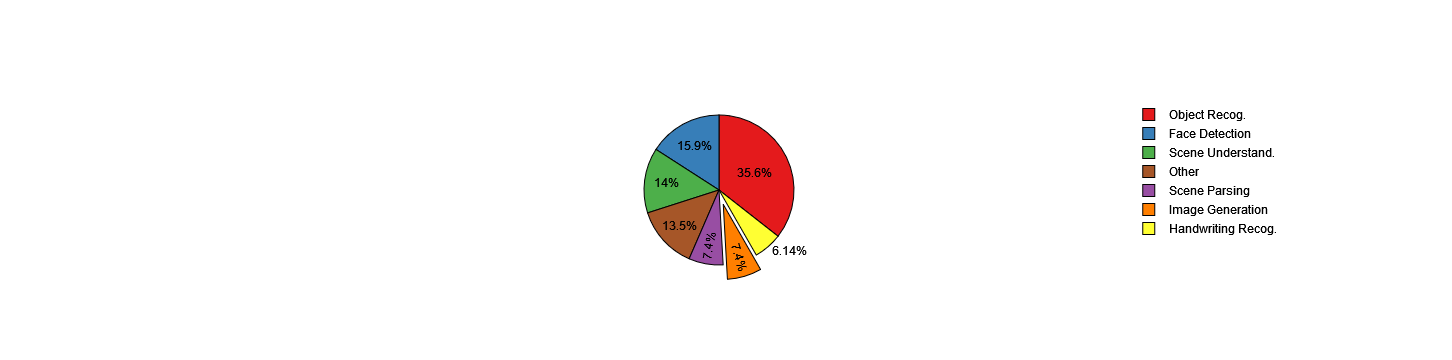

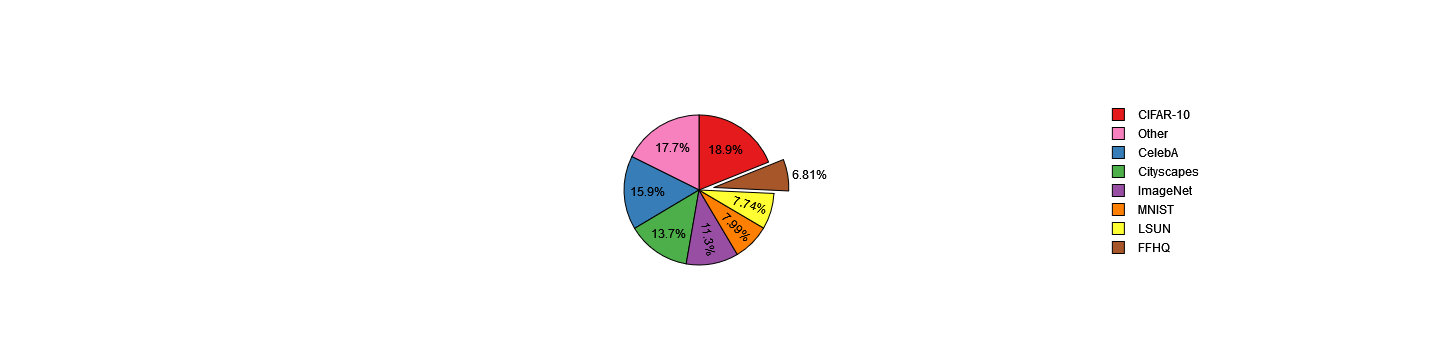

In [384]:
import plotly.graph_objects as go
import plotly.express as px
fig = go.Figure(data=[go.Pie(labels=tasks_df['task'].str.replace("Recognition","Recog.").str.replace("Understanding","Understand."), 
                             values=tasks_df['count'],
                            pull=[0, 0, 0, 0.0,0.2,0,0])])
fig.update_layout(
    font_family="Arial",
    title_font_family="Arial",
    font_color='black',
)
fig.update_traces(marker=dict(colors=px.colors.qualitative.Set1,line=dict(color='#000000', width=1)),textfont_color='black')
fig.show()
fig.write_image("../Figures/ImageGenerationTasks.png",scale=5)
fig.write_image("../Figures/ImageGenerationTasks.svg",scale=5)

fig = go.Figure(data=[go.Pie(labels=dataset_df['name'], 
                             values=dataset_df['count'],
                            pull=[0, 0, 0, 0.0,0,0,0.2,0])])
fig.update_layout(
    font_family="Arial",
    title_font_family="Arial",
    font_color='black',
)
fig.update_traces(marker=dict(colors=px.colors.qualitative.Set1,line=dict(color='#000000', width=1)),textfont_color='black')

#fig.update_traces(marker=dict(colors=px.colors.qualitative.Set3,line=dict(color='#000000', width=1)),textfont_color='black')
#fig.write_image("ImageGenDatasets.svg")
fig.show()
fig.write_image("../Figures/ImageGenerationDatasets.png",scale=5)
fig.write_image("../Figures/ImageGenerationDatasets.svg",scale=5)


In [380]:
tasks_df['task'].str.replace("Recognition","Recog.").str.replace("Understanding","Understand.")

0         Object Recog.
1        Face Detection
2     Scene Understand.
3         Scene Parsing
4      Image Generation
5    Handwriting Recog.
6                 Other
Name: task, dtype: object

In [356]:
p='Face Recognition'
datasets_borrow=source_dest_edgelist[source_dest_edgelist.dest_task==p].drop_duplicates(['name','title']).groupby('name').size().sort_values().to_frame()
datasets_borrow['source']='blue'
datasets_homegrown=homegrown_edgelist[homegrown_edgelist.task==p].drop_duplicates(['name','title']).groupby('name').size().sort_values().to_frame()
datasets_homegrown['source']='orange'
dataset_df=pd.concat([ datasets_borrow,datasets_homegrown]).reset_index().sort_values(0,ascending=False)
dataset_df=dataset_df.rename({0:'count'},axis=1)

tasks_borrow=source_dest_edgelist[source_dest_edgelist.dest_task==p].drop_duplicates(['name','title']).groupby('source_task').size().sort_values().to_frame()
tasks_borrow['source']='blue'
tasks_homegrown=homegrown_edgelist[homegrown_edgelist.task==p].drop_duplicates(['name','title']).groupby('task').size().sort_values().to_frame()
tasks_homegrown['source']='orange'
tasks_df=pd.concat([ tasks_borrow,tasks_homegrown]).reset_index().sort_values(0,ascending=False)
tasks_df=tasks_df.rename({0:'count','index':'task'},axis=1)

dataset_df['cumulative']=dataset_df.sort_values('count',ascending=False)['count'].cumsum()/dataset_df.sort_values('count',ascending=False)['count'].sum()
#tasks_df.set_index('task').plot.pie(y='count')
other_count=dataset_df[dataset_df['cumulative']>.75]['count'].sum()
dataset_df=dataset_df[dataset_df['cumulative']<.75]
dataset_df=dataset_df.append({'name':'Other','count':other_count,'cumulative':1,'source':'gray'},ignore_index=True)

tasks_df['cumulative']=tasks_df.sort_values('count',ascending=False)['count'].cumsum()/tasks_df.sort_values('count',ascending=False)['count'].sum()
#tasks_df.set_index('task').plot.pie(y='count')
other_count=tasks_df[tasks_df['cumulative']>.75]['count'].sum()
tasks_df=tasks_df[tasks_df['cumulative']<.75]
tasks_df=tasks_df.append({'task':'Other','count':other_count,'cumulative':1,'source':'gray'},ignore_index=True)

In [324]:
dataset_df

name  count  source  cumulative
0               LFW    301    blue    0.200533
1     CASIA-WebFace    158  orange    0.305796
2          VGGFace2    130  orange    0.392405
3          MegaFace    110  orange    0.465690
4       MS-Celeb-1M    110  orange    0.538974
5             IJB-A    108  orange    0.610926
6         Multi-PIE     93  orange    0.672885
7            CelebA     75    blue    0.722851
8             IJB-C     74    blue    0.772152
9   Extended Yale B     39  orange    0.798135
10            MORPH     33  orange    0.820120
11         VGG Face     29  orange    0.839440
12            Other    241    gray    1.000000

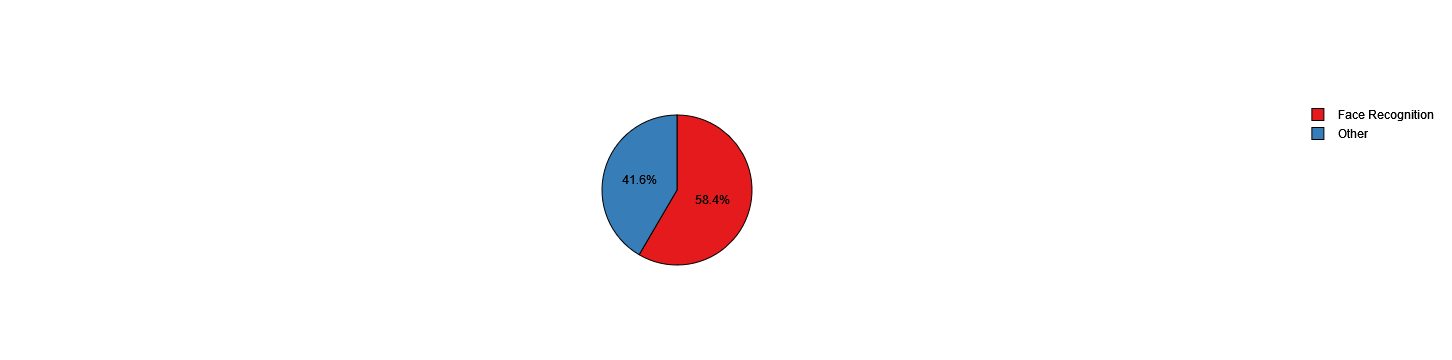

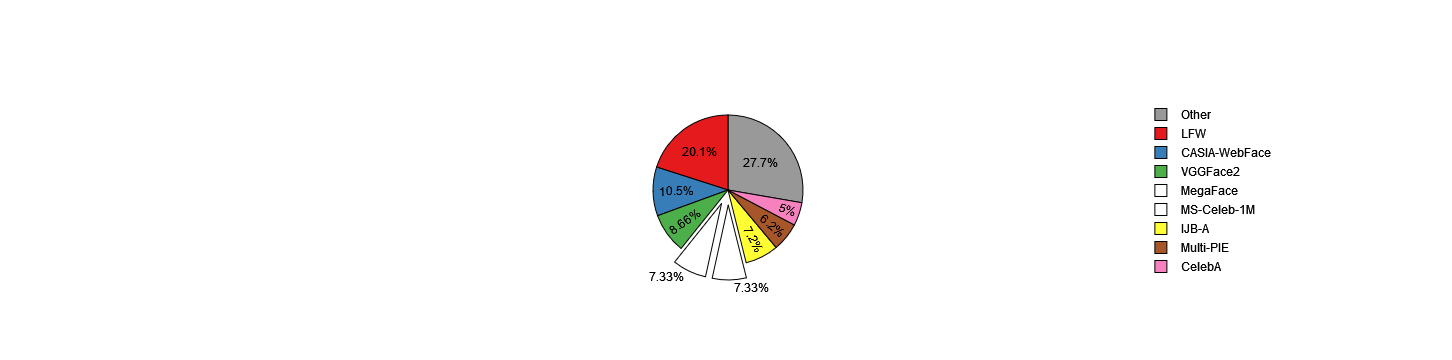

In [357]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=tasks_df['task'], 
                             values=tasks_df['count'],
                            pull=[0, 0, 0, 0.2,0,0,0])])
fig.update_layout(
    font_family="Arial",
    title_font_family="Arial",
    font_color='black',
)
fig.update_traces(marker=dict(colors=px.colors.qualitative.Set1,line=dict(color='#000000', width=1)),textfont_color='black')
fig.show()
temp=[i for i in px.colors.qualitative.Set1]
temp[3]='rgb(255,255,,255)'
temp[4]='rgb(255,255,255)'
temp
fig = go.Figure(data=[go.Pie(labels=dataset_df['name'], 
                             values=dataset_df['count'],
                            pull=[0, 0, 0,.2,.2,0,0])])
fig.update_layout(
    font_family="Arial",
    title_font_family="Arial",
    font_color='black',
)
fig.update_traces(marker=dict(colors=temp,line=dict(color='#000000', width=1)),textfont_color='black')
fig.show()
fig.write_image("../Figures/FaceRecognitionDatasets.svg",scale=5)
fig.write_image("../Figures/FaceRecognitionDatasets.png",scale=5)

In [346]:
help(fig.writeimage)

AttributeError: 'Figure' object has no attribute 'writeimage'

In [293]:
%matplotlib inline
tasks_df['cumulative']=tasks_df.sort_values('count',ascending=False)['count'].cumsum()/tasks_df.sort_values('count',ascending=False)['count'].sum()
#tasks_df.set_index('task').plot.pie(y='count')
other_count=tasks_df[tasks_df['cumulative']>.99]['count'].sum()
tasks_df=tasks_df[tasks_df['cumulative']<.99]
tasks_df=tasks_df.append({'task':'Other','count':other_count,'cumulative':1,'source':'gray'},ignore_index=True)

In [294]:
dataset_df['cumulative']=dataset_df.sort_values('count',ascending=False)['count'].cumsum()/dataset_df.sort_values('count',ascending=False)['count'].sum()
#tasks_df.set_index('task').plot.pie(y='count')
other_count=dataset_df[dataset_df['cumulative']>.99]['count'].sum()
dataset_df=dataset_df[dataset_df['cumulative']<.99]
dataset_df=dataset_df.append({'name':'Other','count':other_count,'cumulative':1,'source':'gray'},ignore_index=True)
dataset_df

name  count  source  cumulative
0    CIFAR-10    225    blue    0.189235
1      CelebA    189    blue    0.348192
2  Cityscapes    163    blue    0.485282
3    ImageNet    134    blue    0.724138
4       MNIST     95    blue    0.804037
5        LSUN     92    blue    0.881413
6        FFHQ     81  orange    0.949537
7       Other    150    gray    0.611438
8       Other     60    gray    1.000000

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Pie(labels=tasks_df['task'], 
                             values=tasks_df['count'],
                            pull=[0, 0, 0, 0.2,0,0,0])])
fig.update_layout(
    font_family="Arial",
    title_font_family="Arial",
    font_color='black',
)
fig.update_traces(marker=dict(colors=px.colors.qualitative.Set1,line=dict(color='#000000', width=1)),textfont_color='black')
fig.show()

fig = go.Figure(data=[go.Pie(labels=dataset_df['name'], 
                             values=dataset_df['count'],
                            pull=[0, 0, 0, 0.2,0,0,0])])
fig.update_layout(
    font_family="Arial",
    title_font_family="Arial",
    font_color='black',
)
fig.update_traces(marker=dict(colors=px.colors.qualitative.Set1,line=dict(color='#000000', width=1)),textfont_color='black')
fig.show()

In [ ]:
inequity_df

In [ ]:
task_ds_ycounts[(task_ds_ycounts.year==2015) & (task_ds_ycounts.task=='3D Human Pose Estimation')]

## Appendix Figures 6 and 7
These two figures appear in the appendix as summaries of the dataset...

In [33]:
%matplotlib inline
source_dest_edgelist=pd.read_csv('./PWC_Data/Derivative_Datasets/source_dest_edgelist.csv')
homegrown_edgelist=pd.read_csv('./PWC_Data/Derivative_Datasets/homegrown_edgelist')
birth_edgelist=pd.read_csv('./PWC_Data/Derivative_Datasets/birth_edgelist.csv')
dataset_papers=datasets[['name','title']]
dataset_papers['date']=None
dest_papers=source_dest_edgelist[['name','title','date']]
dest_papers.columns=['name','title','date']
birth_papers=birth_edgelist[['name','title','date']]
homegrown_papers=homegrown_edgelist[['name','title','date']]
full_dataset=pd.concat([dataset_papers,dest_papers,birth_papers,homegrown_papers]).drop_duplicates()
temp=full_dataset.groupby('name').size().sort_values()
dataset_usage_dist=temp[(temp>5)&(temp<500)].plot(kind='hist',bins=500,figsize=[8,4],title='Truncated Distribution of Dataset Usages')
fig = dataset_usage_dist.get_figure()
fig.savefig('../Appendix/TruncatedDatasetsByUsages.png')


NameError: name 'full_dataset' is not defined

In [ ]:
annual_size=pwc_papers.groupby('year').size().reset_index()
temp=annual_size.plot(figsize=[8,4],x='year',y=0,title='PWC Corpus papers per year',xlim=[2009,2020],legend=False)
fig = temp.get_figure()
fig.savefig('../Appendix/PWCSizebyYear.png')

pwc_papers.title.drop_duplicates().shape